# Objetivos do Trabalho
O objetivo deste trabalho é aplicar métodos de aprendizado por reforço a um problema escolhido e modelado pelos estudantes, comparando os resultados obtidos pelos métodos Monte Carlo, Q-Learning e SARSA(lambda), avaliando: qualidade das soluções, custo computacional, tamanho do espaço de estados, tamanho do espaço de ações e influência da função de reforço no resultado. Também pretende-se aplicar aproximadores lineares de função a cada método e comparar o desempenho de cada método **com** e **sem** o aproximador de função.

# Membros do Grupo e Contribuições

### Ana Clara Zoppi Serpa (RA 165880)
- Implementação do método Monte Carlo
- Implementação do método SARSA(lambda)
- Escrita do relatório
- Formulação do problema como MDP
- Análise de resultados

### Gabriel Oliveira dos Santos (RA 197460)
- Implementação do método Q-Learning
- Implementação do método SARSA
- Experimentos com diferentes funções de reforço, nos métodos Q-Learning e SARSA
- Formulação do problema como MDP

### Silvio Bento Garcia Junior (RA 265194)
- Melhorias nos experimentos com o método de Monte Carlo, explorando diferentes funções de reforço
- Realização de experimentos com os métodos SARSA(lambda) e com o Aproximador Linear de Função em todos os métodos
- Formulação do problema como MDP
- Construção das tabelas com resultados experimentais

### Tito Barbosa Rezende (RA 025327)
- Implementação dos métodos Monte Carlo e SARSA(lambda)
- Implementação do Aproximador Linear de Função para todos os métodos
- Formulação do problema como MDP

# Problema
Escolhemos trabalhar com o jogo Snake, também conhecido como "Serpente" ou "Jogo da Cobrinha", disponível em https://www.google.com/fbx?fbx=snake_arcade.

O jogador é uma cobra, inicialmente pequena, e seu objetivo é comer maçãs. A cobra pode se mover para cima, para baixo, para a esquerda e para a direita. Maçãs aparecem em posições aleatórias do mapa, e o jogador deve se movimentar a fim de passar pela posição que contém a maçã atual. O jogador pode se mover livremente, mas não pode colidir com as bordas do mapa (paredes), nem com seu próprio corpo. Conforme as maçãs são consumidas, o tamanho da cobra aumenta, e há mais risco de colidir com seu próprio corpo ao se movimentar pelo mapa, assim aumentando a dificuldade do jogo.

## Formulação do problema como MDP

Conforme visto em aula, um Processo Decisório de Markov (MDP) é uma tupla <S, P, A, R, gamma>, sendo S um conjunto finito de estados, A um conjunto finito de ações, P uma matriz de probabilidades de transições entre estados, R uma função de reforço e gamma um fator de desconto, que é um número real no intervalo [0,1].

Um estado é uma tupla com 11 valores booleanos:
1. Se há perigo (parede ou o próprio corpo da cobra) uma ou duas unidades do tabuleiro à frente;
2. Se há perigo uma ou duas unidades à direita;
3. Se há perigo uma ou duas unidades à esquerda;
4. Se a cobra está se movendo para a esquerda;
5. Se a cobra está se movendo para a direita;
6. Se a cobra está se movendo para cima;
7. Se a cobra está se movendo para baixo.
8. Se há comida à esquerda;
9. Se há comida à direita;
10. Se há comida para cima;
11. Se há comida para baixo;

Há 2^11 estados possíveis.

Essas direções (esquerda, direita, cima, baixo) são sempre consideradas na perspectiva da cabeça da cobra.

As ações possíveis são:
- Continuar indo na mesma direção, representada pelo vetor [1,0,0];
- Virar para a direita, representada por [0,1,0];
- Virar para a esquerda, representada por [0,0,1];

A tela de jogo tem 440 pixels de largura e 440 pixels de altura. Cada parte do corpo da cobra é um quadrado de 20 pixels de altura e 20 pixels de largura. A maçã tem 20 pixels de altura e 20 pixels de largura também.

A matriz de transição de probabilidades P contém somente uns e zeros, pois dada uma posição (estado) atual no tabuleiro e uma ação, o resultado é sempre o mesmo. Para cada estado atual **s**, estado resultante **s'** quando tomada uma ação **a** e estados restantes **Z** que não são obtidos tomando **a** a partir de **s**, a probabilidade de ir de **s** para **s'** é 1, enquanto que de **s** a qualquer dos **Z** é zero. Isso vale para todos os estados e ações, por isso a matriz terá somente zeros e uns.

Quanto à função de reforço, definimos uma função padrão e depois exploramos outras. Isso será detalhado mais adiante no relatório, assim como os diferentes fatores de desconto (gamma) adotados nos experimentos.

## Natureza do ambiente

* Determinístico ou estocástico: **determinístico**, pois, dado um estado corrente e uma ação, o estado resultante é sempre o mesmo (dada uma posição, a ação de continuar na mesma direção/virar para a direita/virar para a esquerda leva sempre ao mesmo destino).

* Contínuo ou discreto: **discreto**, já que temos um conjunto finito de ações que podemos escolher tomar a partir de um certo estado (virar para a direita, virar para a esquerda, continuar na mesma direção).

* Episódico ou não episódico: **episódico**, sendo cada episódio um jogo. O episódio termina somente quando a cobra morre.

* Single-agent ou multi-agent: **single-agent**, pois nosso único agente é a cobra.

## Modelo de discretização adotado

Como nosso ambiente já é discreto, não precisamos adotar nenhuma estratégia de discretização.

## Estados terminais

Nossos estados terminais são aqueles referentes à morte da cobra, portanto ocorrem somente auando a cobra colide com a parede e quando a cobra colide com seu próprio corpo.

## Funções de Reforço

Nossa **função de reforço padrão** foi -10 quando a cobra morre, +10 quando come a maçã e 0 caso contrário.

```
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward
```

Exploramos também as seguintes funções de reforço alternativas:

* Função **reward1**: visa penalizar a cobra por não estar comendo a maçã.

```
def reward1(env):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -1 otherwise
    """
    reward = -1
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100

    return reward
```

* Função **reward_linear**: visa penalizar a cobra por cada momento em que não melhorar seu desempenho. É possível fornecer diferentes penalizações com o parâmetro penalty_rate.

```
def reward_linear(env, penalty_rate=0.01, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -0.01*non_improvement otherwise
    """
    global non_improvement
    reward = -non_improvement*penalty_rate
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100
        non_improvement = 0
    else:
        non_improvement += 1

    return reward
```

* Função **reward_euclidean**: visa penalizar a cobra quando está longe da maçã, e recompensá-la quando está perto. Implementamos essa função de reforço numa tentativa de melhorar nossos resultados com o algoritmo de Monte Carlo.

```
def reward_euclidean(env):
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = distance.euclidean(player_pos, food_pos)
    reward = 0
    if env.game.crash:
        reward = -10000
    elif env.player.eaten:
        reward = 10000
    else:
        if dist > 100:
            reward = (-1*dist)/10
        if dist <= 100:
            reward = (100-dist)/10

    return reward
```
## Política

A política usada em todos os experimentos foi a **epsilon-greedy**, na qual o agente escolhe suas ações de forma gulosa com respeito à **função ação-valor**. A função ação-valor indica qual é o reforço esperado ao realizar certa ação, estando num certo estado. Dessa forma, agindo gulosamente com respeito à função ação-valor, o agente escolherá ações para as quais ele imagina que receberá a maior quantidade possível de reforço positivo.

No entanto, para garantir que o agente explore outras ações em vez de realizar sempre as mesmas escolhas, com probabilidade epsilon uma ação aleatória será escolhida em vez da ação gulosa.

Os métodos Monte Carlo e SARSA são métodos **on-policy** pois neles a política que o agente busca melhorar é a própria política que ele está utilizando para interagir com o ambiente, no caso, a própria epsilon-greedy. Já o método Q-Learning se caracteriza como **off-policy** pois nele o agente se comporta conforme a epsilon-greedy, mas está procurando aprender outra política.

## Parâmetros

Exploramos os parâmetros gamma, alfa e N0 em nossos experimentos.

* Fator de desconto (gamma): regula o quanto o agente prioriza reforços futuros. Se gamma for baixo, o desconto de reforços futuros é baixo, e o agente dará atenção a possíveis reforços futuros. Se gamma for alto, o desconto será alto, e o agente se comportará priorizando reforços de curto prazo.

* Passo de aprendizado / "step-size" (alfa): regula o ajuste que é realizado na função ação-valor conforme o agente interage com o ambiente, ou seja, o quanto ele aprende com a diferença entre reforços reais e reforços que ele imaginava que receberia com seu comportamento.

* N0: constante utilizada para inicialização dos métodos. É usada no cálculo da probabilidade epsilon da política epsilon-greedy (epsilon = N0/(N0 + N(s_t), sendo N(s_t) o número de visitas a um certo estado s, no instante t).


# Pontos-chave da implementação

### Arquivo agent.py

Neste arquivo há uma classe Agent, que serve como base para as demais (QLearningAgent, MonteCarloAgent, e assim por diante). Ela possui os métodos `choose_action` e `update`. O método `choose_action` é a política, ou seja, escolhe uma ação dado um estado de forma epsilon-greedy. O método `update` é deixado vazio nessa classe, pois cada método tem sua forma de atualizar a função ação-valor (atributo `Q` da classe).

Logo depois da classe Agent, temos as classes específicas para cada método. Um exemplo disso é a classe QLearningAgent, com sua implementação do método update:

```
def update(self, prev_state, next_state, reward, prev_action, next_action):
        """
        Update the action value function using the Q-Learning update.
        Q(S_t, A_t) = Q(S_t, A_t) + alpha(reward + (gamma * Max Q(S_t+1, *) - Q(S_t, A_t))
        Args:
            prev_state: The previous state
            next_state: The next state
            reward: The reward for taking the respective action
            prev_action: The previous action
            next_action: The next action
        Returns:
            None
        """
        alpha = 1 / self.state_action_counter[prev_state, prev_action]
        predict = self.Q[prev_state, prev_action]
        target = reward + self.gamma * np.max(self.Q[next_state, :])
        self.Q[prev_state, prev_action] += alpha * (target - predict)
```

As outras classes (SARSAAgent, SARSALambdaAgent) foram implementadas similarmente, preenchendo o método `update` com a regra de atualização adequada. A classe MonteCarloAgent é uma exceção --- não implementa o método `update` pois a atualização da função ação-valor é realizada diretamente no método que executa os episódios.

### Arquivo base_classes.py

Neste arquivo estão classes relacionadas aos recursos gráficos do jogo e sua execução com a biblioteca PyGame: atualizar posição da cobra na tela, exibir maçãs em novos locais, etc.

### Arquivo environment.py

Temos neste arquivo a classe Environment, com funções `reset`, `step` e `__get_state`. A função `reset` recomeça o jogo uma vez que ele tenha terminado. A função `step` move a cobra conforme a ação que foi escolhida e retorna qual o novo estado e o reforço resultante disso. A função `__get_state` informa o estado atual --- a tupla de 11 booleanos, conforme descrito anteriormente.

### Funções para executar os métodos de aprendizado

Para executar cada método de aprendizado, foram definidas funções no Jupyter Notebook: `run_q_learning`, `run_sarsa`, `run_monte_carlo`. Aqui é exibida como exemplo `run_q_learning`.

- A seed é configurada.
- O ambiente é inicializado.
- Nosso dicionário de métricas é inicializado vazio.
- Guardamos o instante no qual a execução começou.
- Começamos os episódios.
- Um episódio começa com a chamada a env.reset().
- Um episódio está contido no loop `while not done`.
- Dentro da execução do episódio atual, vemos qual o estado e o reforço após a execução da ação 1 escolhida ao iniciarmos o episódio.
- Atualizamos os valores da função ação-valor com uma chamada a `agent.update`.
- Acumulamos o reforço no contador de reforço do episódio corrente.
- Isso será repetido até o episódio acabar, então sempre será escolhida uma próxima ação, obtido um reforço, atualizados os valores `Q` da função valor.
- Quando um episódio acaba, atualizamos as métricas.
- Observação: caso um único jogo (episódio) passe de 10 minutos de duração, ele é interrompido para iniciarmos um novo.
- Quanto todos os episódios acabam, retornamos as métricas.

```
def run_q_learning(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
        

    return metrics
```

### Realização de experimentos

Para realizar um experimento com certo método, definem-se os valores de N0 e gamma, cria-se um agente do tipo desejado e chama-se a função `run_` correspondente, passando como parâmetro a função de reforço, o número de episódios, a velocidade desejada para ver os movimentos da cobra e se o jogo será exibido ou não (variável `display`). Configurando `display` para False, os experimentos demoram menos tempo, então mantivemos `display` configurado como False para coletar os dados. Basta configurar `display=True` para visualizar o jogo.

Como exemplo, segue um experimento que pode ser feito com Q-Learning. Os outros experimentos são análogos.
```
N0 = 1
gamma = 1

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=200, speed=5, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))
```

## Particularidades e restrições da implementação

Para executar o código, é preciso instalar a biblioteca PyGame. Isso pode ser feito com o comando `pip install pygame` no terminal.

# Métodos

Os métodos implementados são métodos de controle, ou seja, que visam melhorar a política conforme o agente interage com o ambiente. Isso é feito por meio da atualização dos valores `Q(s,a)` (função ação-valor), que indicam o reforço que o agente espera receber escolhendo uma ação `a` quando está num estado `s`. Conforme o agente interage com o ambiente e realiza ações, ele recebe reforços reais e ajusta `Q(s,a)`. Como `Q(s,a)` é utilizada nas próximas escolhas, o que ocorre é que o agente mude seu comportamento (**política**) conforme a atualização de `Q(s,a)` e os reforços positivos ou negativos recebidos.

Cada método difere em como atualiza `Q(s,a)`, produzindo diferentes resultados.

## Monte Carlo

### First-Visit

Q(s,a) é inicializado com zeros, assim como N(s,a), que indicará o número de vezes que, no estado **s**, a ação **a** foi escolhida. Epsilon é inicializado com 1, k é inicializado com 1.

Então, para cada episódio k, é feito o *sampling*: o episódio inteiro é executado seguindo a política, ou seja, começa-se num estado s_k_1, realiza-se a ação a_k_1, recebe-se o reforço r_k_1, chega-se ao estado s_k_2, e assim por diante, até o último estado do episódio, denotado por s_k_T.

Uma vez terminado o episódio, calcula-se o retorno dele, guardando na variável G. O retorno é a soma dos reforços obtidos em cada estado, multplicados pelo fator de desconto gamma.

Então, para cada período de 1 a T, atualiza-se N(s,a). No caso do *first-visit Monte Carlo*, N(s,a) será incrementado para contar as primeiras visitas ao estado **s** e ação **a** no episódio k. Também é atualizada a função ação-valor Q(s,a), somando ao valor atual a diferença entre o retorno ganho G_k_t e o retorno esperado Q_st_at, multiplicada pelo passo de aprendizado alfa = 1/N(s,a).

Depois disso, a política é melhorada, usando a atualização de Q(s,a) que acabamos de realizar.

![](montecarlo-first-visit-pseudocode.png)

### Every-Visit

No **every-visit Monte Carlo**, a diferença é que N(s,a) é incrementado considerando todas as visitas ao estado **s** e à ação **a**, em vez de somente a primeira visita. O **every-visit Monte Carlo** apresentou resultados melhores que o first-visit Monte Carlo neste trabalho.

Com o método de Monte Carlo, a atualização de Q(s,a) ocorre somente quando um episódio é terminado, ou seja, um jogo inteiro ocorre, com a cobra seguindo a política atual, e somente então a política é melhorada para ser utilizada num próximo jogo.

## SARSA

Inicializa-se Q(s,a) arbitrariamente, exceto no caso de estados terminais, que precisam ter Q(s,a) = 0. Para cada episódio, inicializa-se o estado atual S e escolhe-se uma ação A usando a política derivada de Q. **Para cada passo de aprendizado dentro do episódio atual**, a ação A escolhida é executada, sendo obtido o reforço R e o novo estado S'. Então, escolhe-se A' a partir de S', usando a política, e atualiza-se Q.

Na atualização de Q, utilizamos o passo de aprendizado alfa, o reforço R obtido, o valor Q(S', A') e o valor Q(S,A): ou seja, estamos atualizando Q(S,A) levando em conta o reforço obtido ao executar A e o reforço que imaginamos receber com Q(S', A').

Atualiza-se o estado atual para S' e a ação atual para A'.

Isso é feito dentro de cada episódio, até que todos os episódios acabem. A principal diferença do SARSA em relação ao Monte Carlo é o aprendizado (atualização de Q) ao longo dos passos do episódio, e não só depois que o episódio já acabou, por ser um método baseado em diferença temporal.

![](sarsa-pseudocode.png)

## SARSA(lambda)

No SARSA(lambda), para cada episódio há um conjunto E(S,A) que será usado na atualização de Q. Para cada passo de aprendizado de um episódio, uma ação A é tomada, sendo obtido o reforço R e um novo estado S'. É escolhida A' a partir de S'. Então, calcula-se delta usando R, o fator de desconto gamma, Q(S', A') e Q(S, A). O valor delta é o reforço obtido executando A, mais o valor que se espera receber executando A', com o desconto temporal gamma, menos o valor que se esperava receber executando A.

E(S,A) é incrementado. Depois, para cada estado s e ação a, atualiza-se Q usando o passo de aprendizado alfa, delta e o valor E(s,a). E(S,A) também é atualizado usando gamma, lambda e E(s,a).

A tabela E(S,A), chamada de **traços de eligibilidade**, deve funcionar como uma ponte entre métodos de diferença temporal e métodos Monte Carlo. Trata-se de uma memória temporária da ocorrência de um evento, então quando ocorre um erro, somente os estados e ações elegíveis são "culpados" pelo erro.

![](sarsa-lambda-pseudocode.png)

## Q-Learning

O Q-Learning é bastante similar ao SARSA, mas a sua forma de atualizar Q(S,A) é diferente. Em vez de utilizar Q(S', A'), utiliza o maior valor dentre os Q(S', a) para todas as ações **a**.

![](qlearning-pseudocode.png)

--- FALAR MAIS DO Q-LEARNING SE DER ---

## Aproximador Linear de Função

Os métodos discutidos armazenam Q(s,a) como uma tabela e atualizam suas entradas conforme o aprendizado. No entanto, para problemas com muitos estados e/ou ações, utilizar tabelas não é viável. Aproximadores de Função aproximam Q(s,a) com uma função parametrizável, então em vez de consultar os valores reais na tabela são usadas aproximações. Podem ser usadas quaisquer aproximações que se deseje, por exemplo, com Redes Neurais. Neste trabalho utilizamos um Aproximador Linear de Função (LFA).

--- FALAR MAIS SOBRE ISSO SE DER, EXPLICANDO FEATURE VECTOR E TALS ---

# Principais Experimentos realizados



# Discussão de Resultados

![](results/tabela-monte-carlo.png)

![](results/tabela-qlearning.png)

![](results/tabela-sarsa.png)

Para o Q-Learning, sem Aproximador Linear de Função, identificamos dois casos que consideramos ótimos:
- Com N0 = 0.5 e gamma = 0.98, utilizando a função de reforço reward_linear sem nenhuma penalização, a cobra obteve 72 como pontuação máxima e 35.1 como média das últimas 50 pontuações, com tempo de execução 74,5140 segundos;
- Com N0 = 0.5 e gamma = 0.98, utilizando a função de reforço reward_linear com penalty_rate = 0.05, a cobra obteve 72 como pontuação máxima e 41.04 como média das últimas 50 pontuações, em 94.3793 segundos;

Para o SARSA, sem Aproximador Linear de Função, também encontramos dois casos que consideramos ótimos:
- N0 = 1, gamma = 1, função de reforço padrão (default_reward): a cobra obteve 70 como pontuação máxima e 30.96 como pontuação média dos 50 últimos jogos, em 30.8162 segundos;
- N0 = 1, gamma = 0.99, função de reforço reward_linear com penalidade = 0.2: a cobra obteve 70 como pontuação máxima e 31.86 como pontuação média dos últimos jogos, em 33.8256 segundos;

O Q-Learning e o SARSA apresentaram casos ótimos bem próximos em termos de pontuação máxima e média das últimas pontuações, mas o tempo de execução do SARSA foi bem menor. Isso sugere que os dois algoritmos são adequados para o problema, e que SARSA tem vantagem sobre Q-Learning na velocidade do aprendizado da cobra.

Os valores de gamma usados foram bem próximos de 1 nestes dois casos, o que indica que priorizar recompensas imediatas ("pensar a curto prazo" em vez de "pensar a longo prazo") é bom para o agente deste problema. Os resultados também indicam que a função de reforço padrão e a função de reforço reward_linear com uma pequena penalização para momentos nos quais a cobra não melhorou sua pontuação são adequadas para o problema.

Para o método Monte Carlo, exploramos as funções de recompensa padrão e reward_euclidean, que busca penalizar a cobra por estar distante da maçã. Exploramos tanto a variante first-visit quanto a variante every-visit. Os bons casos que identificamos são:

- (First Visit) N0 = 1, gamma = 0.2, reward_euclidean: pontuação máxima = 27, média das últimas 50 pontuações = 7.48, tempo de execução = 99.6431 segundos.
- (First Visit) N0 = 1, gamma = 0.2, default_reward: pontuação máxima = 28, média das últimas 50 pontuações = 8.44, tempo de execução = 10.0414 segundos.
- (Every Visit) N0 = 1, gamma = 0.5, default_reward: pontuação máxima = 50, média das últimas 50 pontuações = 2.2020, tempo de execução = 10.5174 segundos.
- (Every Visit) N0 = 1, gamma = 1, default_reward: pontuação máxima = 49, média das últimas 50 pontuações = 16.84, tempo de execução = 8.6560 segundos.

Monte Carlo every-visit foi melhor que first-visit para o problema, mas ainda bastante inferior aos métodos SARSA e Q-Learning em termos de pontuação máxima. Como o método de Monte Carlo atualiza os valores da função ação-valor somente ao final de um episódio (jogo), esse resultado é compatível com nossa expectativa de que seu desempenho fosse pior para este problema. Todos os métodos foram comparados com a mesma quantidade de episódios (1000), e acreditamos que o método de Monte Carlo precisaria de mais episódios para atingir pontuações maiores.

Quanto à função de recompensa reward_euclidean, observamos que, para o início do jogo, funciona bem, incentivando a cobra a se aproximar da maçã. No entanto, conforme o comprimento da cobra aumenta, se aproximar da maçã sem antes se afastar para contornar e evitar colisões com seu próprio corpo causa sua morte. Assim, reward_euclidean é boa para os estágios iniciais do jogo, mas não para todo o jogo. Um experimento futuro interessante seria alterar a função de reforço conforme o comprimento da cobra, unindo as melhores características da função padrão à função reward_euclidean.

# Observações

Na próxima seção, colocamos o código-fonte da implementação. Ao executá-lo, uma janela com o jogo será aberta, mas ficará preta pois desabilitamos os recursos gráficos a fim de realizar medições mais rápidas dos dados que precisamos.

Se desejar ver as animações dos experimentos, apesar de demorarem, basta alterar o parâmetro display das chamadas a run_q_learning, run_monte_carlo e run_sarsa para True.

# Referências

- Aulas da professora, disponibilizadas no Google Classroom da disciplina.

- Livro Reinforcement Learning: An Introduction, Sutton and Barto, 2a Edição.

### Artigos e exemplos de implementação

- Artigo sobre Snake com Deep Q-Learning: https://towardsdatascience.com/how-to-teach-an-ai-to-play-games-deep-reinforcement-learning-28f9b920440a

- Repositório do GitHub com Snake e Deep Q-Learning, no qual nos baseamos inicialmente para realizar o projeto: https://github.com/maurock/snake-ga

- Exemplo de implementação do SARSA: https://www.geeksforgeeks.org/expected-sarsa-in-reinforcement-learning/

- Artigo sobre SARSA(lambda) para vários jogos, inclusive Snake: http://cs229.stanford.edu/proj2012/JohnsonRobertsFisher-LearningToPlay2DVideoGames.pdf

- Exemplo de implementação de Aproximador de Função: https://github.com/metastableB/Naagin-Naggin/blob/master/dlsnake/agents/approxQAgent.py

- Exemplos de implementações de SARSA e Monte Carlo: https://github.com/ralhadeff/machine-learning-tools/tree/master/ReinforcementLearning

- Exemplos de implementações baseados no livro Reinforcement Learning: An Introduction: https://github.com/flyywh/reinforcement-learning-1

- Artigos sobre Snake, Q-Learning e SARSA: https://dkdennis.xyz/static/Nagging-report.pdf, http://cs229.stanford.edu/proj2016spr/report/060.pdf

### Outras páginas

- https://towardsdatascience.com/reinforcement-learning-rl-101-with-python-e1aa0d37d43b

- https://towardsdatascience.com/slitherin-solving-the-classic-game-of-snake-with-ai-part-2-general-purpose-random-monte-25dc0dd4c4cf

- https://towardsdatascience.com/function-approximation-in-reinforcement-learning-85a4864d566

- https://towardsdatascience.com/monte-carlo-learning-b83f75233f92

- https://medium.com/reinforcement-learning-a-step-by-step-implementati/reinforcement-learning-a-step-by-step-implementation-using-sarsa-1cfd3e64775a

- https://www.programmersought.com/article/94202345056/

- https://www.youtube.com/watch?v=l0sFUU7vScA

# Código-fonte e experimentos

Nessa seção, juntamos o código-fonte e os experimentos desenvolvidos para cada algoritmo, que originalmente foram mantidos em Jupyter Notebooks separados.

## Experimenos com Q-Learning

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agent import Agent, QLearningAgent
from environment import Environment
from screen import Screen

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [4]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [5]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


In [6]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

In [7]:
def run_q_learning(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
        

    return metrics

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

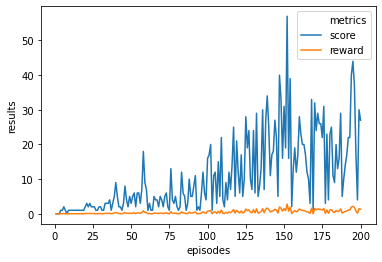

Run time: 143.3214728832245 seconds
Max. Score: 57
Mean Last Scores: 20.32


In [9]:
N0 = 1
gamma = 1

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=200, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

Game 353      Score: 31
Game 354      Score: 19
Game 355      Score: 30
Game 356      Score: 27
Game 357      Score: 23
Game 358      Score: 12
Game 359      Score: 16
Game 360      Score: 15
Game 361      Score: 31
Game 362      Score: 4
Game 363      Score: 11
Game 364      Score: 34
Game 365      Score: 5
Game 366      Score: 31
Game 367      Score: 27
Game 368      Score: 26
Game 369      Score: 27
Game 370      Score: 27
Game 371      Score: 23
Game 372      Score: 13
Game 373      Score: 34
Game 374      Score: 28
Game 375      Score: 22
Game 376      Score: 28
Game 377      Score: 24
Game 378      Score: 16
Game 379      Score: 6
Game 380      Score: 15
Game 381      Score: 31
Game 382      Score: 20
Game 383      Score: 34
Game 384      Score: 32
Game 385      Score: 31
Game 386      Score: 26
Game 387      Score: 31
Game 388      Score: 15
Game 389      Score: 14
Game 390      Score: 14
Game 391      Score: 19
Game 392      Score: 26
Game 393      Score: 22
Game 394      Score

Game 695      Score: 24
Game 696      Score: 29
Game 697      Score: 31
Game 698      Score: 15
Game 699      Score: 17
Game 700      Score: 16
Game 701      Score: 24
Game 702      Score: 17
Game 703      Score: 29
Game 704      Score: 40
Game 705      Score: 26
Game 706      Score: 36
Game 707      Score: 11
Game 708      Score: 12
Game 709      Score: 29
Game 710      Score: 20
Game 711      Score: 26
Game 712      Score: 19
Game 713      Score: 18
Game 714      Score: 24
Game 715      Score: 30
Game 716      Score: 23
Game 717      Score: 22
Game 718      Score: 19
Game 719      Score: 13
Game 720      Score: 21
Game 721      Score: 31
Game 722      Score: 19
Game 723      Score: 21
Game 724      Score: 24
Game 725      Score: 27
Game 726      Score: 14
Game 727      Score: 21
Game 728      Score: 27
Game 729      Score: 27
Game 730      Score: 12
Game 731      Score: 29
Game 732      Score: 20
Game 733      Score: 21
Game 734      Score: 25
Game 735      Score: 9
Game 736      Sco

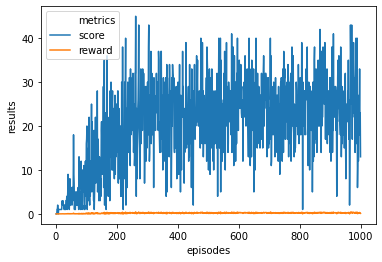

Run time: 332.2784593105316 seconds
Max. Score: 45
Mean Last Scores: 24.46


In [8]:
N0 = 1
gamma = 0.99

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

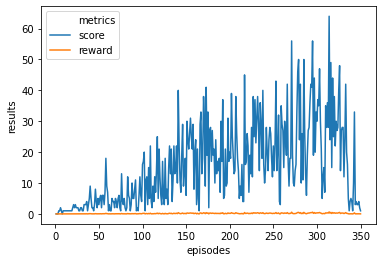

Run time: 600.05149102211 seconds
Max. Score: 64
Mean Last Scores: 21.68


In [16]:
N0 = 1
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

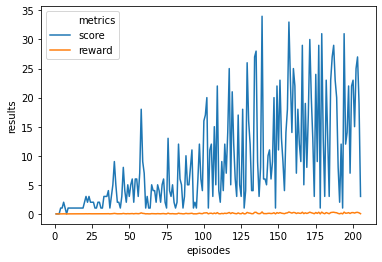

Run time: 600.0537443161011 seconds
Max. Score: 34
Mean Last Scores: 16.78


In [11]:
N0 = 1
gamma = 0.95

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 4
Game 27      Score: 3
Game 28      Score: 5
Game 29      Score: 3
Game 30      Score: 5
Game 31      Score: 2
Game 32      Score: 5
Game 33      Score: 10
Game 34      Score: 18
Game 35      Score: 3
Game 36      Score: 7
Game 37      Score: 4
Game 38      Score: 11
Game 39      Score: 3
Game 40      Score: 6
Game 41      Score: 1
Game 42      Score: 3
Game 43      Score: 10
Game 44      Score: 6
Game 45      Score: 2
Game 46      Sc

Game 354      Score: 31
Game 355      Score: 54
Game 356      Score: 34
Game 357      Score: 15
Game 358      Score: 8
Game 359      Score: 25
Game 360      Score: 35
Game 361      Score: 47
Game 362      Score: 26
Game 363      Score: 55
Game 364      Score: 30
Game 365      Score: 22
Game 366      Score: 47
Game 367      Score: 27
Game 368      Score: 16
Game 369      Score: 32
Game 370      Score: 39
Game 371      Score: 41
Game 372      Score: 38
Game 373      Score: 31
Game 374      Score: 30
Game 375      Score: 36
Game 376      Score: 27
Game 377      Score: 32
Game 378      Score: 18
Game 379      Score: 51
Game 380      Score: 28
Game 381      Score: 21
Game 382      Score: 58
Game 383      Score: 26
Game 384      Score: 31
Game 385      Score: 35
Game 386      Score: 43
Game 387      Score: 47
Game 388      Score: 39
Game 389      Score: 57
Game 390      Score: 38
Game 391      Score: 30
Game 392      Score: 30
Game 393      Score: 34
Game 394      Score: 28
Game 395      Sco

Game 697      Score: 45
Game 698      Score: 24
Game 699      Score: 30
Game 700      Score: 40
Game 701      Score: 11
Game 702      Score: 38
Game 703      Score: 38
Game 704      Score: 35
Game 705      Score: 19
Game 706      Score: 28
Game 707      Score: 29
Game 708      Score: 51
Game 709      Score: 33
Game 710      Score: 33
Game 711      Score: 20
Game 712      Score: 26
Game 713      Score: 22
Game 714      Score: 14
Game 715      Score: 21
Game 716      Score: 19
Game 717      Score: 36
Game 718      Score: 18
Game 719      Score: 38
Game 720      Score: 45
Game 721      Score: 19
Game 722      Score: 10
Game 723      Score: 16
Game 724      Score: 43
Game 725      Score: 38
Game 726      Score: 40
Game 727      Score: 37
Game 728      Score: 29
Game 729      Score: 41
Game 730      Score: 17
Game 731      Score: 23
Game 732      Score: 14
Game 733      Score: 31
Game 734      Score: 14
Game 735      Score: 31
Game 736      Score: 27
Game 737      Score: 20
Game 738      Sc

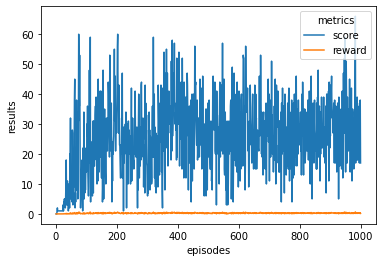

Run time: 44.54111289978027 seconds
Max. Score: 66


In [11]:
N0 = 0.75
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 1
Game 29      Score: 0
Game 30      Score: 2
Game 31      Score: 0
Game 32      Score: 1
Game 33      Score: 0
Game 34      Score: 1
Game 35      Score: 0
Game 36      Score: 2
Game 37      Score: 4
Game 38      Score: 0
Game 39      Score: 2
Game 40      Score: 10
Game 41      Score: 2
Game 42      Score: 5
Game 43      Score: 4
Game 44      Score: 6
Game 45      Score: 2
Game 46      Score

Game 353      Score: 40
Game 354      Score: 33
Game 355      Score: 2
Game 356      Score: 27
Game 357      Score: 39
Game 358      Score: 31
Game 359      Score: 27
Game 360      Score: 23
Game 361      Score: 30
Game 362      Score: 30
Game 363      Score: 40
Game 364      Score: 23
Game 365      Score: 37
Game 366      Score: 26
Game 367      Score: 35
Game 368      Score: 14
Game 369      Score: 28
Game 370      Score: 22
Game 371      Score: 20
Game 372      Score: 36
Game 373      Score: 31
Game 374      Score: 45
Game 375      Score: 23
Game 376      Score: 43
Game 377      Score: 46
Game 378      Score: 44
Game 379      Score: 42
Game 380      Score: 20
Game 381      Score: 36
Game 382      Score: 33
Game 383      Score: 18
Game 384      Score: 39
Game 385      Score: 27
Game 386      Score: 31
Game 387      Score: 25
Game 388      Score: 30
Game 389      Score: 28
Game 390      Score: 30
Game 391      Score: 24
Game 392      Score: 33
Game 393      Score: 33
Game 394      Sco

Game 697      Score: 39
Game 698      Score: 30
Game 699      Score: 39
Game 700      Score: 57
Game 701      Score: 57
Game 702      Score: 41
Game 703      Score: 21
Game 704      Score: 26
Game 705      Score: 21
Game 706      Score: 36
Game 707      Score: 34
Game 708      Score: 31
Game 709      Score: 17
Game 710      Score: 41
Game 711      Score: 27
Game 712      Score: 33
Game 713      Score: 43
Game 714      Score: 36
Game 715      Score: 25
Game 716      Score: 26
Game 717      Score: 28
Game 718      Score: 21
Game 719      Score: 33
Game 720      Score: 26
Game 721      Score: 22
Game 722      Score: 26
Game 723      Score: 41
Game 724      Score: 37
Game 725      Score: 12
Game 726      Score: 36
Game 727      Score: 34
Game 728      Score: 33
Game 729      Score: 48
Game 730      Score: 40
Game 731      Score: 10
Game 732      Score: 20
Game 733      Score: 27
Game 734      Score: 34
Game 735      Score: 37
Game 736      Score: 30
Game 737      Score: 47
Game 738      Sc

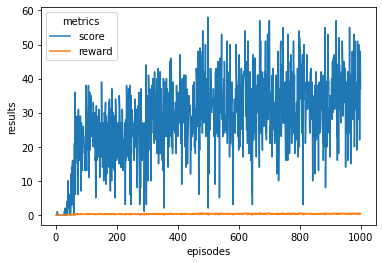

Run time: 58.652116775512695 seconds
Max. Score: 58


In [12]:
N0 = 0.5
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 3
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 3
Game 13      Score: 3
Game 14      Score: 3
Game 15      Score: 2
Game 16      Score: 0
Game 17      Score: 2
Game 18      Score: 4
Game 19      Score: 3
Game 20      Score: 2
Game 21      Score: 4
Game 22      Score: 4
Game 23      Score: 8
Game 24      Score: 5
Game 25      Score: 3
Game 26      Score: 13
Game 27      Score: 3
Game 28      Score: 8
Game 29      Score: 5
Game 30      Score: 7
Game 31      Score: 7
Game 32      Score: 7
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 12
Game 36      Score: 2
Game 37      Score: 3
Game 38      Score: 8
Game 39      Score: 5
Game 40      Score: 7
Game 41      Score: 5
Game 42      Score: 3
Game 43      Score: 6
Game 44      Score: 9
Game 45      Score: 5
Game 46      Scor

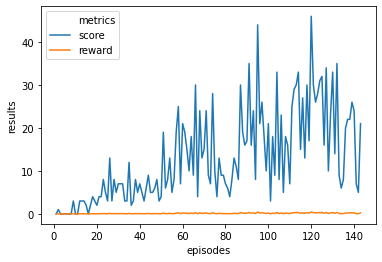

Run time: 600.0218884944916 seconds
Max. Score: 46
Mean Last Scores: 20.7


In [12]:
N0 = 0.25
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 1
Game 20      Score: 3
Game 21      Score: 3
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 4
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 4
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 5
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 1
Game 39      Score: 2
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 0
Game 43      Score: 4
Game 44      Score: 1
Game 45      Score: 4
Game 46      Score:

Game 363      Score: 16
Game 364      Score: 12
Game 365      Score: 11
Game 366      Score: 22
Game 367      Score: 14
Game 368      Score: 6
Game 369      Score: 5
Game 370      Score: 15
Game 371      Score: 8
Game 372      Score: 15
Game 373      Score: 24
Game 374      Score: 22
Game 375      Score: 11
Game 376      Score: 8
Game 377      Score: 13
Game 378      Score: 24
Game 379      Score: 19
Game 380      Score: 36
Game 381      Score: 19
Game 382      Score: 14
Game 383      Score: 12
Game 384      Score: 22
Game 385      Score: 14
Game 386      Score: 19
Game 387      Score: 25
Game 388      Score: 20
Game 389      Score: 11
Game 390      Score: 10
Game 391      Score: 12
Game 392      Score: 34
Game 393      Score: 16
Game 394      Score: 16
Game 395      Score: 9
Game 396      Score: 10
Game 397      Score: 15
Game 398      Score: 19
Game 399      Score: 15
Game 400      Score: 9
Game 401      Score: 23
Game 402      Score: 27
Game 403      Score: 31
Game 404      Score: 1

Game 708      Score: 36
Game 709      Score: 19
Game 710      Score: 33
Game 711      Score: 1
Game 712      Score: 25
Game 713      Score: 30
Game 714      Score: 19
Game 715      Score: 31
Game 716      Score: 29
Game 717      Score: 24
Game 718      Score: 27
Game 719      Score: 32
Game 720      Score: 23
Game 721      Score: 16
Game 722      Score: 28
Game 723      Score: 14
Game 724      Score: 36
Game 725      Score: 13
Game 726      Score: 17
Game 727      Score: 38
Game 728      Score: 26
Game 729      Score: 11
Game 730      Score: 35
Game 731      Score: 34
Game 732      Score: 18
Game 733      Score: 37
Game 734      Score: 6
Game 735      Score: 24
Game 736      Score: 39
Game 737      Score: 14
Game 738      Score: 5
Game 739      Score: 23
Game 740      Score: 18
Game 741      Score: 28
Game 742      Score: 25
Game 743      Score: 25
Game 744      Score: 20
Game 745      Score: 19
Game 746      Score: 35
Game 747      Score: 19
Game 748      Score: 25
Game 749      Score

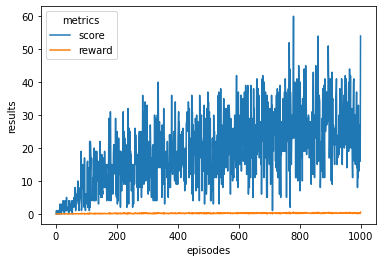

Run time: 25.89958643913269 seconds
Max. Score: 60


In [14]:
N0 = 2
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 2
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 0
Game 21      Score: 1
Game 22      Score: 0
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 1
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 2
Game 44      Score: 0
Game 45      Score: 2
Game 46      Score:

Game 356      Score: 12
Game 357      Score: 10
Game 358      Score: 12
Game 359      Score: 22
Game 360      Score: 5
Game 361      Score: 9
Game 362      Score: 16
Game 363      Score: 3
Game 364      Score: 14
Game 365      Score: 22
Game 366      Score: 20
Game 367      Score: 18
Game 368      Score: 15
Game 369      Score: 9
Game 370      Score: 14
Game 371      Score: 16
Game 372      Score: 10
Game 373      Score: 21
Game 374      Score: 23
Game 375      Score: 8
Game 376      Score: 20
Game 377      Score: 10
Game 378      Score: 12
Game 379      Score: 17
Game 380      Score: 18
Game 381      Score: 12
Game 382      Score: 15
Game 383      Score: 22
Game 384      Score: 27
Game 385      Score: 11
Game 386      Score: 4
Game 387      Score: 18
Game 388      Score: 11
Game 389      Score: 17
Game 390      Score: 18
Game 391      Score: 19
Game 392      Score: 15
Game 393      Score: 21
Game 394      Score: 23
Game 395      Score: 8
Game 396      Score: 10
Game 397      Score: 30

Game 706      Score: 23
Game 707      Score: 13
Game 708      Score: 26
Game 709      Score: 30
Game 710      Score: 29
Game 711      Score: 26
Game 712      Score: 11
Game 713      Score: 22
Game 714      Score: 20
Game 715      Score: 16
Game 716      Score: 26
Game 717      Score: 15
Game 718      Score: 35
Game 719      Score: 4
Game 720      Score: 46
Game 721      Score: 20
Game 722      Score: 10
Game 723      Score: 21
Game 724      Score: 24
Game 725      Score: 27
Game 726      Score: 19
Game 727      Score: 29
Game 728      Score: 30
Game 729      Score: 29
Game 730      Score: 23
Game 731      Score: 16
Game 732      Score: 26
Game 733      Score: 16
Game 734      Score: 17
Game 735      Score: 9
Game 736      Score: 22
Game 737      Score: 10
Game 738      Score: 43
Game 739      Score: 16
Game 740      Score: 34
Game 741      Score: 28
Game 742      Score: 30
Game 743      Score: 23
Game 744      Score: 16
Game 745      Score: 35
Game 746      Score: 33
Game 747      Scor

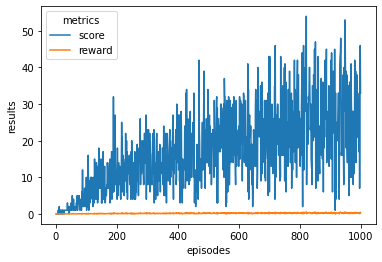

Run time: 21.196118593215942 seconds
Max. Score: 54


In [15]:
N0 = 4
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 2
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 0
Game 16      Score: 2
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 2
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 3
Game 26      Score: 0
Game 27      Score: 1
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 2
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 1
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 359      Score: 16
Game 360      Score: 10
Game 361      Score: 16
Game 362      Score: 19
Game 363      Score: 5
Game 364      Score: 13
Game 365      Score: 12
Game 366      Score: 10
Game 367      Score: 10
Game 368      Score: 4
Game 369      Score: 11
Game 370      Score: 8
Game 371      Score: 23
Game 372      Score: 14
Game 373      Score: 4
Game 374      Score: 22
Game 375      Score: 20
Game 376      Score: 9
Game 377      Score: 24
Game 378      Score: 7
Game 379      Score: 4
Game 380      Score: 12
Game 381      Score: 4
Game 382      Score: 9
Game 383      Score: 3
Game 384      Score: 13
Game 385      Score: 12
Game 386      Score: 12
Game 387      Score: 19
Game 388      Score: 5
Game 389      Score: 13
Game 390      Score: 3
Game 391      Score: 7
Game 392      Score: 17
Game 393      Score: 12
Game 394      Score: 4
Game 395      Score: 7
Game 396      Score: 7
Game 397      Score: 11
Game 398      Score: 17
Game 399      Score: 8
Game 400      Score: 19
Game 401 

Game 709      Score: 20
Game 710      Score: 13
Game 711      Score: 14
Game 712      Score: 27
Game 713      Score: 10
Game 714      Score: 9
Game 715      Score: 3
Game 716      Score: 21
Game 717      Score: 13
Game 718      Score: 16
Game 719      Score: 4
Game 720      Score: 20
Game 721      Score: 17
Game 722      Score: 22
Game 723      Score: 17
Game 724      Score: 6
Game 725      Score: 6
Game 726      Score: 25
Game 727      Score: 20
Game 728      Score: 17
Game 729      Score: 11
Game 730      Score: 15
Game 731      Score: 15
Game 732      Score: 7
Game 733      Score: 12
Game 734      Score: 9
Game 735      Score: 14
Game 736      Score: 20
Game 737      Score: 16
Game 738      Score: 18
Game 739      Score: 10
Game 740      Score: 10
Game 741      Score: 8
Game 742      Score: 13
Game 743      Score: 14
Game 744      Score: 19
Game 745      Score: 19
Game 746      Score: 9
Game 747      Score: 21
Game 748      Score: 7
Game 749      Score: 34
Game 750      Score: 12
Ga

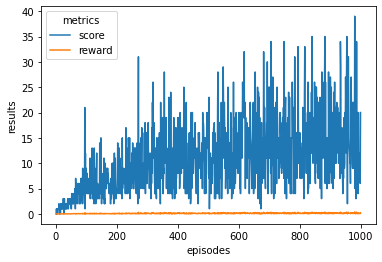

Run time: 14.676084280014038 seconds
Max. Score: 39


In [16]:
N0 = 10
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### Experimentando variar a função de recompensa


Game 1      Score: 2
Game 2      Score: 1
Game 3      Score: 5
Game 4      Score: 4
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 3
Game 8      Score: 1
Game 9      Score: 3
Game 10      Score: 2
Game 11      Score: 10
Game 12      Score: 6
Game 13      Score: 4
Game 14      Score: 2
Game 15      Score: 5
Game 16      Score: 6
Game 17      Score: 2
Game 18      Score: 2
Game 19      Score: 7
Game 20      Score: 6
Game 21      Score: 6
Game 22      Score: 6
Game 23      Score: 6
Game 24      Score: 6
Game 25      Score: 4
Game 26      Score: 7
Game 27      Score: 6
Game 28      Score: 9
Game 29      Score: 4
Game 30      Score: 6
Game 31      Score: 3
Game 32      Score: 5
Game 33      Score: 4
Game 34      Score: 9
Game 35      Score: 3
Game 36      Score: 7
Game 37      Score: 8
Game 38      Score: 6
Game 39      Score: 6
Game 40      Score: 4
Game 41      Score: 11
Game 42      Score: 12
Game 43      Score: 11
Game 44      Score: 14
Game 45      Score: 13
Game 46      

Game 351      Score: 8
Game 352      Score: 42
Game 353      Score: 35
Game 354      Score: 18
Game 355      Score: 25
Game 356      Score: 10
Game 357      Score: 30
Game 358      Score: 23
Game 359      Score: 30
Game 360      Score: 48
Game 361      Score: 22
Game 362      Score: 24
Game 363      Score: 37
Game 364      Score: 29
Game 365      Score: 46
Game 366      Score: 23
Game 367      Score: 23
Game 368      Score: 16
Game 369      Score: 22
Game 370      Score: 24
Game 371      Score: 33
Game 372      Score: 36
Game 373      Score: 31
Game 374      Score: 34
Game 375      Score: 4
Game 376      Score: 18
Game 377      Score: 25
Game 378      Score: 21
Game 379      Score: 49
Game 380      Score: 32
Game 381      Score: 50
Game 382      Score: 19
Game 383      Score: 43
Game 384      Score: 37
Game 385      Score: 33
Game 386      Score: 35
Game 387      Score: 42
Game 388      Score: 23
Game 389      Score: 28
Game 390      Score: 30
Game 391      Score: 44
Game 392      Scor

Game 697      Score: 11
Game 698      Score: 43
Game 699      Score: 7
Game 700      Score: 41
Game 701      Score: 40
Game 702      Score: 24
Game 703      Score: 30
Game 704      Score: 64
Game 705      Score: 37
Game 706      Score: 19
Game 707      Score: 23
Game 708      Score: 32
Game 709      Score: 28
Game 710      Score: 32
Game 711      Score: 29
Game 712      Score: 58
Game 713      Score: 38
Game 714      Score: 38
Game 715      Score: 20
Game 716      Score: 31
Game 717      Score: 34
Game 718      Score: 19
Game 719      Score: 45
Game 720      Score: 37
Game 721      Score: 31
Game 722      Score: 35
Game 723      Score: 32
Game 724      Score: 25
Game 725      Score: 28
Game 726      Score: 41
Game 727      Score: 43
Game 728      Score: 12
Game 729      Score: 25
Game 730      Score: 29
Game 731      Score: 34
Game 732      Score: 40
Game 733      Score: 44
Game 734      Score: 28
Game 735      Score: 26
Game 736      Score: 38
Game 737      Score: 29
Game 738      Sco

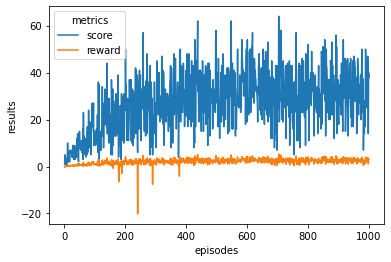

Run time: 42.418917179107666 seconds
Max. Score: 64


In [17]:
def reward1(env):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -1 otherwise
    """
    reward = -1
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100

    return reward
    

N0 = 0.5
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=reward1, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [18]:
import math
from scipy.spatial.distance import cityblock

def reward_exp(env, max_value, max_dist=3, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        +max_value * exp(dist[snake, food]) if dist[snake, food] <= max_dist
        -0.01*non_improvement otherwise
    """
    global non_improvement
    
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = dist_metric(player_pos, food_pos)
    
    reward = max_value * math.exp(dist)
    if env.game.crash:
        reward = -1000
    elif env.player.eaten:
        reward = 1000
        non_improvement = 0
    elif dist >= max_dist:
        reward = -non_improvement*0.01
        non_improvement += 1

    return reward

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 1
Game 31      Score: 2
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 3
Game 36      Score: 3
Game 37      Score: 1
Game 38      Score: 1
Game 39      Score: 1
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 3
Game 43      Score: 3
Game 44      Score: 3
Game 45      Score: 1
Game 46      Score:

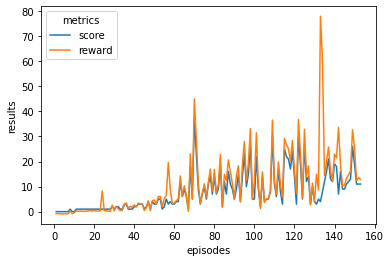

Run time: 600.4343683719635 seconds
Max. Score: 37


In [19]:
N0 = 0.5
gamma = 0.98
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_exp(env, max_value=10),
                         episodes=1000, speed=1, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [7]:
import math
from scipy.spatial.distance import cityblock

def reward_linear(env, penalty_rate=0.01, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -0.01*non_improvement otherwise
    """
    global non_improvement
    reward = -non_improvement*penalty_rate
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100
        non_improvement = 0
    else:
        non_improvement += 1

    return reward

In [13]:
N0 = 0.5
gamma = 0.98
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=reward_linear,
                         episodes=1000, speed=1, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

NameError: name 'reward_linear' is not defined

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 2
Game 26      Score: 3
Game 27      Score: 3
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 2
Game 34      Score: 2
Game 35      Score: 2
Game 36      Score: 2
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 4
Game 40      Score: 3
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 5
Game 44      Score: 7
Game 45      Score: 5
Game 46      Score:

Game 352      Score: 33
Game 353      Score: 19
Game 354      Score: 45
Game 355      Score: 25
Game 356      Score: 41
Game 357      Score: 16
Game 358      Score: 34
Game 359      Score: 31
Game 360      Score: 17
Game 361      Score: 22
Game 362      Score: 27
Game 363      Score: 42
Game 364      Score: 23
Game 365      Score: 8
Game 366      Score: 30
Game 367      Score: 43
Game 368      Score: 15
Game 369      Score: 9
Game 370      Score: 25
Game 371      Score: 50
Game 372      Score: 32
Game 373      Score: 30
Game 374      Score: 31
Game 375      Score: 24
Game 376      Score: 53
Game 377      Score: 50
Game 378      Score: 37
Game 379      Score: 30
Game 380      Score: 31
Game 381      Score: 46
Game 382      Score: 32
Game 383      Score: 29
Game 384      Score: 4
Game 385      Score: 26
Game 386      Score: 26
Game 387      Score: 40
Game 388      Score: 23
Game 389      Score: 21
Game 390      Score: 36
Game 391      Score: 46
Game 392      Score: 33
Game 393      Score

Game 695      Score: 51
Game 696      Score: 20
Game 697      Score: 42
Game 698      Score: 18
Game 699      Score: 17
Game 700      Score: 31
Game 701      Score: 30
Game 702      Score: 28
Game 703      Score: 45
Game 704      Score: 26
Game 705      Score: 34
Game 706      Score: 40
Game 707      Score: 36
Game 708      Score: 31
Game 709      Score: 25
Game 710      Score: 33
Game 711      Score: 14
Game 712      Score: 48
Game 713      Score: 18
Game 714      Score: 36
Game 715      Score: 20
Game 716      Score: 18
Game 717      Score: 38
Game 718      Score: 49
Game 719      Score: 40
Game 720      Score: 33
Game 721      Score: 30
Game 722      Score: 35
Game 723      Score: 36
Game 724      Score: 38
Game 725      Score: 42
Game 726      Score: 26
Game 727      Score: 21
Game 728      Score: 26
Game 729      Score: 29
Game 730      Score: 39
Game 731      Score: 36
Game 732      Score: 51
Game 733      Score: 32
Game 734      Score: 32
Game 735      Score: 10
Game 736      Sc

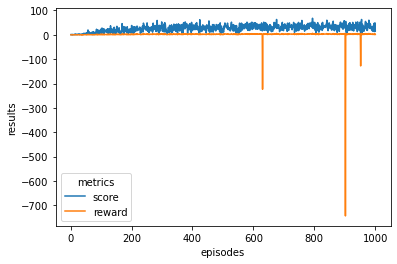

Run time: 54.022438764572144 seconds
Max. Score: 68
Mean Last Scores: 32.1


In [92]:
N0 = 0.5
gamma = 0.98
global non_improvement 
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.02),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 2
Game 26      Score: 3
Game 27      Score: 3
Game 28      Score: 4
Game 29      Score: 2
Game 30      Score: 5
Game 31      Score: 1
Game 32      Score: 3
Game 33      Score: 4
Game 34      Score: 3
Game 35      Score: 1
Game 36      Score: 5
Game 37      Score: 5
Game 38      Score: 1
Game 39      Score: 2
Game 40      Score: 7
Game 41      Score: 4
Game 42      Score: 4
Game 43      Score: 3
Game 44      Score: 4
Game 45      Score: 1
Game 46      Score:

Game 352      Score: 22
Game 353      Score: 31
Game 354      Score: 30
Game 355      Score: 42
Game 356      Score: 42
Game 357      Score: 42
Game 358      Score: 15
Game 359      Score: 36
Game 360      Score: 34
Game 361      Score: 46
Game 362      Score: 39
Game 363      Score: 25
Game 364      Score: 28
Game 365      Score: 33
Game 366      Score: 32
Game 367      Score: 42
Game 368      Score: 39
Game 369      Score: 57
Game 370      Score: 42
Game 371      Score: 56
Game 372      Score: 55
Game 373      Score: 21
Game 374      Score: 37
Game 375      Score: 53
Game 376      Score: 25
Game 377      Score: 25
Game 378      Score: 41
Game 379      Score: 42
Game 380      Score: 27
Game 381      Score: 16
Game 382      Score: 37
Game 383      Score: 34
Game 384      Score: 5
Game 385      Score: 29
Game 386      Score: 35
Game 387      Score: 27
Game 388      Score: 26
Game 389      Score: 24
Game 390      Score: 27
Game 391      Score: 45
Game 392      Score: 32
Game 393      Sco

Game 694      Score: 20
Game 695      Score: 29
Game 696      Score: 34
Game 697      Score: 53
Game 698      Score: 30
Game 699      Score: 51
Game 700      Score: 52
Game 701      Score: 17
Game 702      Score: 48
Game 703      Score: 17
Game 704      Score: 40
Game 705      Score: 28
Game 706      Score: 10
Game 707      Score: 32
Game 708      Score: 40
Game 709      Score: 52
Game 710      Score: 37
Game 711      Score: 33
Game 712      Score: 37
Game 713      Score: 17
Game 714      Score: 43
Game 715      Score: 25
Game 716      Score: 52
Game 717      Score: 19
Game 718      Score: 9
Game 719      Score: 39
Game 720      Score: 44
Game 721      Score: 41
Game 722      Score: 34
Game 723      Score: 21
Game 724      Score: 11
Game 725      Score: 58
Game 726      Score: 32
Game 727      Score: 36
Game 728      Score: 51
Game 729      Score: 31
Game 730      Score: 20
Game 731      Score: 55
Game 732      Score: 31
Game 733      Score: 41
Game 734      Score: 65
Game 735      Sco

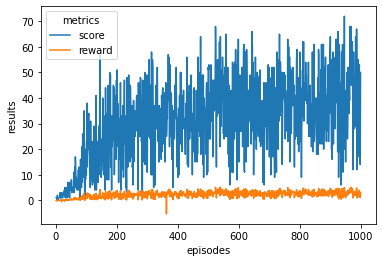

Run time: 94.37932229042053 seconds
Max. Score: 72
Mean Last Scores: 41.04


In [91]:
N0 = 0.5
gamma = 0.98
global non_improvement 
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.05),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 2
Game 23      Score: 2
Game 24      Score: 5
Game 25      Score: 4
Game 26      Score: 2
Game 27      Score: 3
Game 28      Score: 2
Game 29      Score: 1
Game 30      Score: 5
Game 31      Score: 2
Game 32      Score: 2
Game 33      Score: 2
Game 34      Score: 2
Game 35      Score: 4
Game 36      Score: 1
Game 37      Score: 2
Game 38      Score: 4
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 4
Game 42      Score: 3
Game 43      Score: 5
Game 44      Score: 2
Game 45      Score: 4
Game 46      Score:

Game 352      Score: 35
Game 353      Score: 25
Game 354      Score: 37
Game 355      Score: 58
Game 356      Score: 40
Game 357      Score: 41
Game 358      Score: 26
Game 359      Score: 34
Game 360      Score: 20
Game 361      Score: 38
Game 362      Score: 18
Game 363      Score: 45
Game 364      Score: 31
Game 365      Score: 35
Game 366      Score: 30
Game 367      Score: 16
Game 368      Score: 33
Game 369      Score: 42
Game 370      Score: 21
Game 371      Score: 49
Game 372      Score: 39
Game 373      Score: 18
Game 374      Score: 36
Game 375      Score: 16
Game 376      Score: 32
Game 377      Score: 42
Game 378      Score: 44
Game 379      Score: 22
Game 380      Score: 31
Game 381      Score: 12
Game 382      Score: 43
Game 383      Score: 36
Game 384      Score: 58
Game 385      Score: 51
Game 386      Score: 17
Game 387      Score: 29
Game 388      Score: 39
Game 389      Score: 22
Game 390      Score: 26
Game 391      Score: 21
Game 392      Score: 18
Game 393      Sc

Game 694      Score: 41
Game 695      Score: 41
Game 696      Score: 44
Game 697      Score: 37
Game 698      Score: 25
Game 699      Score: 21
Game 700      Score: 27
Game 701      Score: 45
Game 702      Score: 44
Game 703      Score: 38
Game 704      Score: 14
Game 705      Score: 23
Game 706      Score: 40
Game 707      Score: 22
Game 708      Score: 34
Game 709      Score: 33
Game 710      Score: 16
Game 711      Score: 24
Game 712      Score: 38
Game 713      Score: 30
Game 714      Score: 52
Game 715      Score: 43
Game 716      Score: 42
Game 717      Score: 47
Game 718      Score: 39
Game 719      Score: 36
Game 720      Score: 26
Game 721      Score: 32
Game 722      Score: 16
Game 723      Score: 36
Game 724      Score: 58
Game 725      Score: 55
Game 726      Score: 13
Game 727      Score: 27
Game 728      Score: 20
Game 729      Score: 56
Game 730      Score: 31
Game 731      Score: 18
Game 732      Score: 41
Game 733      Score: 45
Game 734      Score: 36
Game 735      Sc

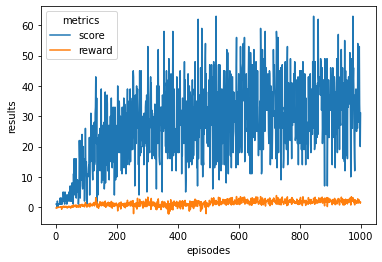

Run time: 69.07219433784485 seconds
Max. Score: 63
Mean Last Scores: 34.22


In [87]:
N0 = 0.5
gamma = 0.98
global non_improvement 
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.1),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 4
Game 21      Score: 3
Game 22      Score: 3
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 1
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 1
Game 29      Score: 1
Game 30      Score: 3
Game 31      Score: 1
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 2
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 5
Game 38      Score: 6
Game 39      Score: 5
Game 40      Score: 4
Game 41      Score: 9
Game 42      Score: 3
Game 43      Score: 4
Game 44      Score: 5
Game 45      Score: 4
Game 46      Score:

Game 353      Score: 35
Game 354      Score: 18
Game 355      Score: 17
Game 356      Score: 43
Game 357      Score: 29
Game 358      Score: 24
Game 359      Score: 29
Game 360      Score: 28
Game 361      Score: 14
Game 362      Score: 34
Game 363      Score: 41
Game 364      Score: 27
Game 365      Score: 29
Game 366      Score: 40
Game 367      Score: 12
Game 368      Score: 34
Game 369      Score: 30
Game 370      Score: 22
Game 371      Score: 23
Game 372      Score: 36
Game 373      Score: 39
Game 374      Score: 37
Game 375      Score: 14
Game 376      Score: 38
Game 377      Score: 29
Game 378      Score: 20
Game 379      Score: 33
Game 380      Score: 37
Game 381      Score: 7
Game 382      Score: 32
Game 383      Score: 51
Game 384      Score: 13
Game 385      Score: 30
Game 386      Score: 41
Game 387      Score: 19
Game 388      Score: 34
Game 389      Score: 26
Game 390      Score: 21
Game 391      Score: 19
Game 392      Score: 43
Game 393      Score: 18
Game 394      Sco

Game 696      Score: 41
Game 697      Score: 23
Game 698      Score: 23
Game 699      Score: 34
Game 700      Score: 39
Game 701      Score: 22
Game 702      Score: 31
Game 703      Score: 40
Game 704      Score: 42
Game 705      Score: 22
Game 706      Score: 16
Game 707      Score: 31
Game 708      Score: 25
Game 709      Score: 26
Game 710      Score: 33
Game 711      Score: 39
Game 712      Score: 23
Game 713      Score: 22
Game 714      Score: 28
Game 715      Score: 22
Game 716      Score: 30
Game 717      Score: 8
Game 718      Score: 23
Game 719      Score: 4
Game 720      Score: 39
Game 721      Score: 43
Game 722      Score: 32
Game 723      Score: 16
Game 724      Score: 13
Game 725      Score: 37
Game 726      Score: 24
Game 727      Score: 40
Game 728      Score: 19
Game 729      Score: 40
Game 730      Score: 19
Game 731      Score: 20
Game 732      Score: 45
Game 733      Score: 6
Game 734      Score: 14
Game 735      Score: 12
Game 736      Score: 46
Game 737      Score

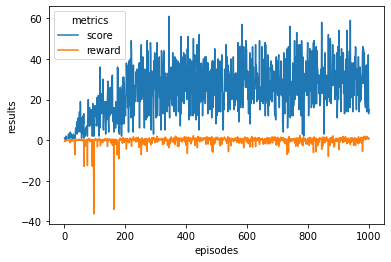

Run time: 55.069982051849365 seconds
Max. Score: 61
Mean Last Scores: 30.28


In [86]:
N0 = 0.5
gamma = 0.98
global non_improvement 
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.2),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 5
Game 20      Score: 1
Game 21      Score: 2
Game 22      Score: 1
Game 23      Score: 3
Game 24      Score: 1
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 1
Game 29      Score: 3
Game 30      Score: 1
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 1
Game 35      Score: 2
Game 36      Score: 3
Game 37      Score: 3
Game 38      Score: 4
Game 39      Score: 3
Game 40      Score: 8
Game 41      Score: 2
Game 42      Score: 3
Game 43      Score: 2
Game 44      Score: 4
Game 45      Score: 15
Game 46      Score

Game 356      Score: 33
Game 357      Score: 34
Game 358      Score: 23
Game 359      Score: 37
Game 360      Score: 34
Game 361      Score: 40
Game 362      Score: 31
Game 363      Score: 6
Game 364      Score: 24
Game 365      Score: 18
Game 366      Score: 27
Game 367      Score: 38
Game 368      Score: 31
Game 369      Score: 14
Game 370      Score: 31
Game 371      Score: 25
Game 372      Score: 12
Game 373      Score: 19
Game 374      Score: 47
Game 375      Score: 9
Game 376      Score: 27
Game 377      Score: 40
Game 378      Score: 15
Game 379      Score: 18
Game 380      Score: 30
Game 381      Score: 46
Game 382      Score: 35
Game 383      Score: 29
Game 384      Score: 31
Game 385      Score: 21
Game 386      Score: 25
Game 387      Score: 11
Game 388      Score: 31
Game 389      Score: 38
Game 390      Score: 31
Game 391      Score: 32
Game 392      Score: 21
Game 393      Score: 2
Game 394      Score: 37
Game 395      Score: 22
Game 396      Score: 34
Game 397      Score

Game 700      Score: 24
Game 701      Score: 36
Game 702      Score: 14
Game 703      Score: 19
Game 704      Score: 33
Game 705      Score: 27
Game 706      Score: 29
Game 707      Score: 36
Game 708      Score: 32
Game 709      Score: 45
Game 710      Score: 27
Game 711      Score: 40
Game 712      Score: 27
Game 713      Score: 49
Game 714      Score: 22
Game 715      Score: 53
Game 716      Score: 32
Game 717      Score: 46
Game 718      Score: 40
Game 719      Score: 24
Game 720      Score: 52
Game 721      Score: 41
Game 722      Score: 26
Game 723      Score: 45
Game 724      Score: 29
Game 725      Score: 52
Game 726      Score: 31
Game 727      Score: 27
Game 728      Score: 32
Game 729      Score: 24
Game 730      Score: 11
Game 731      Score: 50
Game 732      Score: 48
Game 733      Score: 25
Game 734      Score: 27
Game 735      Score: 22
Game 736      Score: 47
Game 737      Score: 37
Game 738      Score: 31
Game 739      Score: 25
Game 740      Score: 27
Game 741      Sc

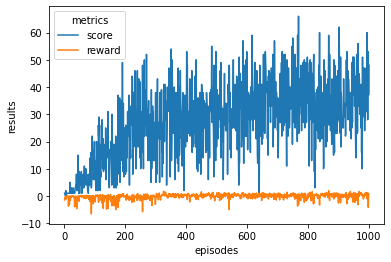

Run time: 44.748507499694824 seconds
Max. Score: 66
Mean Last Scores: 36.72


In [88]:
N0 = 0.5
gamma = 0.98
global non_improvement 
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.5),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

## Experimentos com SARSA

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agent import Agent, SARSAAgent
from environment import Environment
from screen import Screen

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [3]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [4]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


In [5]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

In [6]:
def run_sarsa(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
        

    return metrics

N0 = 1
gamma = 1

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 3
Game 29      Score: 5
Game 30      Score: 4
Game 31      Score: 7
Game 32      Score: 4
Game 33      Score: 5
Game 34      Score: 2
Game 35      Score: 3
Game 36      Score: 3
Game 37      Score: 4
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 4
Game 41      Score: 4
Game 42      Score: 7
Game 43      Score: 3
Game 44      Score: 4
Game 45      Score: 11
Game 46      Score

Game 356      Score: 27
Game 357      Score: 43
Game 358      Score: 27
Game 359      Score: 20
Game 360      Score: 30
Game 361      Score: 13
Game 362      Score: 11
Game 363      Score: 27
Game 364      Score: 18
Game 365      Score: 5
Game 366      Score: 38
Game 367      Score: 27
Game 368      Score: 32
Game 369      Score: 37
Game 370      Score: 33
Game 371      Score: 28
Game 372      Score: 49
Game 373      Score: 30
Game 374      Score: 22
Game 375      Score: 30
Game 376      Score: 22
Game 377      Score: 43
Game 378      Score: 23
Game 379      Score: 30
Game 380      Score: 44
Game 381      Score: 21
Game 382      Score: 33
Game 383      Score: 33
Game 384      Score: 38
Game 385      Score: 42
Game 386      Score: 34
Game 387      Score: 46
Game 388      Score: 22
Game 389      Score: 32
Game 390      Score: 12
Game 391      Score: 25
Game 392      Score: 20
Game 393      Score: 22
Game 394      Score: 29
Game 395      Score: 28
Game 396      Score: 24
Game 397      Sco

Game 698      Score: 33
Game 699      Score: 37
Game 700      Score: 37
Game 701      Score: 18
Game 702      Score: 43
Game 703      Score: 16
Game 704      Score: 52
Game 705      Score: 34
Game 706      Score: 41
Game 707      Score: 30
Game 708      Score: 41
Game 709      Score: 33
Game 710      Score: 42
Game 711      Score: 52
Game 712      Score: 41
Game 713      Score: 48
Game 714      Score: 56
Game 715      Score: 45
Game 716      Score: 50
Game 717      Score: 52
Game 718      Score: 29
Game 719      Score: 25
Game 720      Score: 29
Game 721      Score: 41
Game 722      Score: 23
Game 723      Score: 28
Game 724      Score: 16
Game 725      Score: 42
Game 726      Score: 42
Game 727      Score: 30
Game 728      Score: 39
Game 729      Score: 22
Game 730      Score: 40
Game 731      Score: 25
Game 732      Score: 20
Game 733      Score: 32
Game 734      Score: 29
Game 735      Score: 36
Game 736      Score: 11
Game 737      Score: 34
Game 738      Score: 24
Game 739      Sc

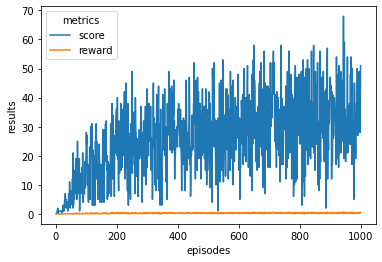

Run time: 28.250312566757202 seconds
Max. Score: 68
Mean Last Scores: 33.0


In [8]:
N0 = 1
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 3
Game 29      Score: 5
Game 30      Score: 4
Game 31      Score: 7
Game 32      Score: 4
Game 33      Score: 5
Game 34      Score: 2
Game 35      Score: 3
Game 36      Score: 3
Game 37      Score: 4
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 4
Game 41      Score: 4
Game 42      Score: 7
Game 43      Score: 3
Game 44      Score: 4
Game 45      Score: 11
Game 46      Score

Game 354      Score: 19
Game 355      Score: 19
Game 356      Score: 19
Game 357      Score: 26
Game 358      Score: 31
Game 359      Score: 43
Game 360      Score: 19
Game 361      Score: 20
Game 362      Score: 18
Game 363      Score: 25
Game 364      Score: 18
Game 365      Score: 19
Game 366      Score: 18
Game 367      Score: 16
Game 368      Score: 39
Game 369      Score: 34
Game 370      Score: 20
Game 371      Score: 30
Game 372      Score: 37
Game 373      Score: 17
Game 374      Score: 32
Game 375      Score: 15
Game 376      Score: 19
Game 377      Score: 16
Game 378      Score: 19
Game 379      Score: 28
Game 380      Score: 30
Game 381      Score: 20
Game 382      Score: 31
Game 383      Score: 34
Game 384      Score: 19
Game 385      Score: 24
Game 386      Score: 11
Game 387      Score: 28
Game 388      Score: 26
Game 389      Score: 32
Game 390      Score: 27
Game 391      Score: 25
Game 392      Score: 21
Game 393      Score: 29
Game 394      Score: 43
Game 395      Sc

Game 700      Score: 47
Game 701      Score: 13
Game 702      Score: 35
Game 703      Score: 39
Game 704      Score: 27
Game 705      Score: 21
Game 706      Score: 46
Game 707      Score: 19
Game 708      Score: 36
Game 709      Score: 15
Game 710      Score: 34
Game 711      Score: 32
Game 712      Score: 25
Game 713      Score: 36
Game 714      Score: 22
Game 715      Score: 20
Game 716      Score: 40
Game 717      Score: 25
Game 718      Score: 29
Game 719      Score: 18
Game 720      Score: 33
Game 721      Score: 40
Game 722      Score: 15
Game 723      Score: 12
Game 724      Score: 36
Game 725      Score: 17
Game 726      Score: 49
Game 727      Score: 32
Game 728      Score: 38
Game 729      Score: 8
Game 730      Score: 41
Game 731      Score: 29
Game 732      Score: 27
Game 733      Score: 36
Game 734      Score: 29
Game 735      Score: 35
Game 736      Score: 29
Game 737      Score: 28
Game 738      Score: 33
Game 739      Score: 42
Game 740      Score: 12
Game 741      Sco

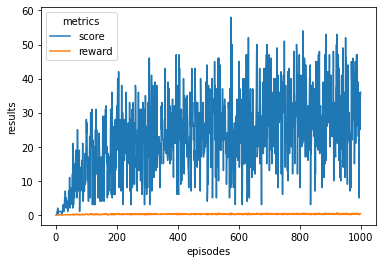

Run time: 26.12573480606079 seconds
Max. Score: 58
Mean Last Scores: 30.46


In [9]:
N0 = 1
gamma = 0.98

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 3
Game 29      Score: 5
Game 30      Score: 4
Game 31      Score: 7
Game 32      Score: 4
Game 33      Score: 5
Game 34      Score: 2
Game 35      Score: 3
Game 36      Score: 3
Game 37      Score: 4
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 4
Game 41      Score: 4
Game 42      Score: 7
Game 43      Score: 3
Game 44      Score: 4
Game 45      Score: 11
Game 46      Score

Game 357      Score: 42
Game 358      Score: 31
Game 359      Score: 30
Game 360      Score: 23
Game 361      Score: 20
Game 362      Score: 17
Game 363      Score: 21
Game 364      Score: 22
Game 365      Score: 22
Game 366      Score: 14
Game 367      Score: 10
Game 368      Score: 20
Game 369      Score: 24
Game 370      Score: 15
Game 371      Score: 24
Game 372      Score: 13
Game 373      Score: 48
Game 374      Score: 16
Game 375      Score: 27
Game 376      Score: 3
Game 377      Score: 26
Game 378      Score: 30
Game 379      Score: 38
Game 380      Score: 43
Game 381      Score: 24
Game 382      Score: 21
Game 383      Score: 29
Game 384      Score: 36
Game 385      Score: 19
Game 386      Score: 23
Game 387      Score: 35
Game 388      Score: 33
Game 389      Score: 21
Game 390      Score: 19
Game 391      Score: 13
Game 392      Score: 23
Game 393      Score: 21
Game 394      Score: 27
Game 395      Score: 22
Game 396      Score: 33
Game 397      Score: 40
Game 398      Sco

Game 702      Score: 45
Game 703      Score: 11
Game 704      Score: 22
Game 705      Score: 34
Game 706      Score: 28
Game 707      Score: 37
Game 708      Score: 24
Game 709      Score: 41
Game 710      Score: 47
Game 711      Score: 11
Game 712      Score: 43
Game 713      Score: 22
Game 714      Score: 49
Game 715      Score: 19
Game 716      Score: 42
Game 717      Score: 25
Game 718      Score: 2
Game 719      Score: 15
Game 720      Score: 41
Game 721      Score: 25
Game 722      Score: 34
Game 723      Score: 35
Game 724      Score: 18
Game 725      Score: 34
Game 726      Score: 59
Game 727      Score: 31
Game 728      Score: 23
Game 729      Score: 31
Game 730      Score: 45
Game 731      Score: 22
Game 732      Score: 34
Game 733      Score: 40
Game 734      Score: 49
Game 735      Score: 33
Game 736      Score: 25
Game 737      Score: 36
Game 738      Score: 35
Game 739      Score: 24
Game 740      Score: 23
Game 741      Score: 9
Game 742      Score: 55
Game 743      Scor

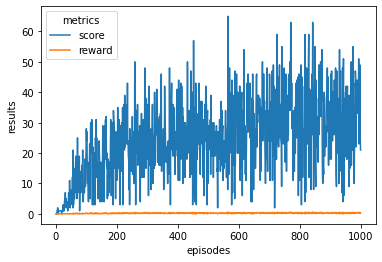

Run time: 28.081741333007812 seconds
Max. Score: 65
Mean Last Scores: 32.06


In [10]:
N0 = 1
gamma = 0.95

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [14]:
N0 = 0.75
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

NameError: name 'SARSAAgent' is not defined

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 4
Game 38      Score: 4
Game 39      Score: 1
Game 40      Score: 1
Game 41      Score: 2
Game 42      Score: 0
Game 43      Score: 3
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 356      Score: 30
Game 357      Score: 15
Game 358      Score: 4
Game 359      Score: 16
Game 360      Score: 21
Game 361      Score: 23
Game 362      Score: 12
Game 363      Score: 15
Game 364      Score: 12
Game 365      Score: 32
Game 366      Score: 18
Game 367      Score: 28
Game 368      Score: 15
Game 369      Score: 11
Game 370      Score: 13
Game 371      Score: 11
Game 372      Score: 21
Game 373      Score: 21
Game 374      Score: 27
Game 375      Score: 17
Game 376      Score: 23
Game 377      Score: 9
Game 378      Score: 9
Game 379      Score: 33
Game 380      Score: 23
Game 381      Score: 25
Game 382      Score: 25
Game 383      Score: 14
Game 384      Score: 18
Game 385      Score: 3
Game 386      Score: 10
Game 387      Score: 17
Game 388      Score: 13
Game 389      Score: 13
Game 390      Score: 20
Game 391      Score: 23
Game 392      Score: 20
Game 393      Score: 30
Game 394      Score: 11
Game 395      Score: 26
Game 396      Score: 16
Game 397      Score:

Game 704      Score: 18
Game 705      Score: 19
Game 706      Score: 16
Game 707      Score: 15
Game 708      Score: 28
Game 709      Score: 23
Game 710      Score: 12
Game 711      Score: 11
Game 712      Score: 44
Game 713      Score: 15
Game 714      Score: 18
Game 715      Score: 12
Game 716      Score: 20
Game 717      Score: 14
Game 718      Score: 16
Game 719      Score: 24
Game 720      Score: 26
Game 721      Score: 28
Game 722      Score: 22
Game 723      Score: 11
Game 724      Score: 16
Game 725      Score: 30
Game 726      Score: 27
Game 727      Score: 22
Game 728      Score: 12
Game 729      Score: 8
Game 730      Score: 26
Game 731      Score: 31
Game 732      Score: 25
Game 733      Score: 24
Game 734      Score: 27
Game 735      Score: 11
Game 736      Score: 22
Game 737      Score: 22
Game 738      Score: 13
Game 739      Score: 33
Game 740      Score: 22
Game 741      Score: 21
Game 742      Score: 17
Game 743      Score: 17
Game 744      Score: 13
Game 745      Sco

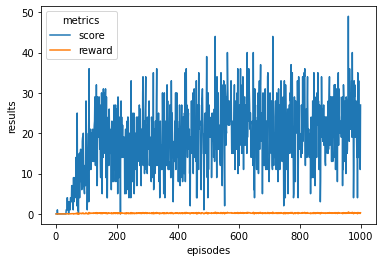

Run time: 43.579917192459106 seconds
Max. Score: 49
Mean Last Scores: 23.24


In [27]:
N0 = 0.5
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 3
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 3
Game 13      Score: 3
Game 14      Score: 3
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 3
Game 22      Score: 3
Game 23      Score: 3
Game 24      Score: 4
Game 25      Score: 4
Game 26      Score: 4
Game 27      Score: 10
Game 28      Score: 2
Game 29      Score: 5
Game 30      Score: 3
Game 31      Score: 7
Game 32      Score: 5
Game 33      Score: 4
Game 34      Score: 4
Game 35      Score: 15
Game 36      Score: 6
Game 37      Score: 14
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 3
Game 41      Score: 8
Game 42      Score: 7
Game 43      Score: 3
Game 44      Score: 4
Game 45      Score: 11
Game 46      Sc

Game 356      Score: 16
Game 357      Score: 47
Game 358      Score: 36
Game 359      Score: 24
Game 360      Score: 18
Game 361      Score: 19
Game 362      Score: 5
Game 363      Score: 39
Game 364      Score: 42
Game 365      Score: 20
Game 366      Score: 13
Game 367      Score: 30
Game 368      Score: 23
Game 369      Score: 35
Game 370      Score: 35
Game 371      Score: 25
Game 372      Score: 25
Game 373      Score: 23
Game 374      Score: 41
Game 375      Score: 15
Game 376      Score: 17
Game 377      Score: 42
Game 378      Score: 10
Game 379      Score: 18
Game 380      Score: 6
Game 381      Score: 38
Game 382      Score: 23
Game 383      Score: 28
Game 384      Score: 24
Game 385      Score: 9
Game 386      Score: 17
Game 387      Score: 31
Game 388      Score: 16
Game 389      Score: 24
Game 390      Score: 13
Game 391      Score: 20
Game 392      Score: 26
Game 393      Score: 14
Game 394      Score: 28
Game 395      Score: 35
Game 396      Score: 25
Game 397      Score

Game 699      Score: 54
Game 700      Score: 22
Game 701      Score: 21
Game 702      Score: 40
Game 703      Score: 40
Game 704      Score: 6
Game 705      Score: 23
Game 706      Score: 20
Game 707      Score: 33
Game 708      Score: 14
Game 709      Score: 27
Game 710      Score: 51
Game 711      Score: 39
Game 712      Score: 33
Game 713      Score: 15
Game 714      Score: 13
Game 715      Score: 47
Game 716      Score: 20
Game 717      Score: 30
Game 718      Score: 33
Game 719      Score: 14
Game 720      Score: 34
Game 721      Score: 33
Game 722      Score: 22
Game 723      Score: 30
Game 724      Score: 22
Game 725      Score: 50
Game 726      Score: 22
Game 727      Score: 40
Game 728      Score: 44
Game 729      Score: 41
Game 730      Score: 19
Game 731      Score: 14
Game 732      Score: 52
Game 733      Score: 30
Game 734      Score: 8
Game 735      Score: 13
Game 736      Score: 30
Game 737      Score: 5
Game 738      Score: 13
Game 739      Score: 13
Game 740      Score

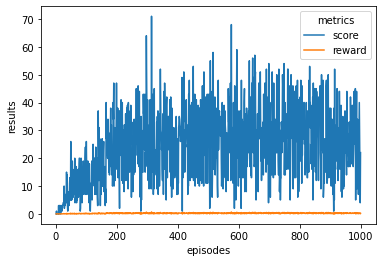

Run time: 256.46834087371826 seconds
Max. Score: 71
Mean Last Scores: 25.74


In [28]:
N0 = 0.25
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 1
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 2
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 2
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 3
Game 21      Score: 1
Game 22      Score: 8
Game 23      Score: 2
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 4
Game 29      Score: 3
Game 30      Score: 2
Game 31      Score: 2
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 2
Game 35      Score: 2
Game 36      Score: 18
Game 37      Score: 0
Game 38      Score: 9
Game 39      Score: 11
Game 40      Score: 4
Game 41      Score: 7
Game 42      Score: 7
Game 43      Score: 9
Game 44      Score: 4
Game 45      Score: 15
Game 46      Sco

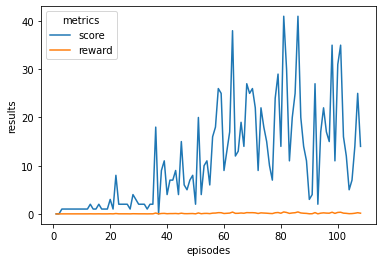

Run time: 600.0150225162506 seconds
Max. Score: 41
Mean Last Scores: 18.66


In [30]:
N0 = 0.1
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 0
Game 20      Score: 4
Game 21      Score: 1
Game 22      Score: 2
Game 23      Score: 2
Game 24      Score: 1
Game 25      Score: 0
Game 26      Score: 6
Game 27      Score: 1
Game 28      Score: 2
Game 29      Score: 4
Game 30      Score: 3
Game 31      Score: 6
Game 32      Score: 2
Game 33      Score: 5
Game 34      Score: 4
Game 35      Score: 4
Game 36      Score: 5
Game 37      Score: 5
Game 38      Score: 5
Game 39      Score: 2
Game 40      Score: 10
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 8
Game 44      Score: 8
Game 45      Score: 4
Game 46      Score

Game 360      Score: 13
Game 361      Score: 33
Game 362      Score: 10
Game 363      Score: 20
Game 364      Score: 14
Game 365      Score: 29
Game 366      Score: 32
Game 367      Score: 7
Game 368      Score: 26
Game 369      Score: 21
Game 370      Score: 22
Game 371      Score: 15
Game 372      Score: 5
Game 373      Score: 8
Game 374      Score: 18
Game 375      Score: 11
Game 376      Score: 5
Game 377      Score: 4
Game 378      Score: 30
Game 379      Score: 20
Game 380      Score: 27
Game 381      Score: 7
Game 382      Score: 25
Game 383      Score: 20
Game 384      Score: 17
Game 385      Score: 18
Game 386      Score: 11
Game 387      Score: 20
Game 388      Score: 20
Game 389      Score: 9
Game 390      Score: 12
Game 391      Score: 13
Game 392      Score: 31
Game 393      Score: 12
Game 394      Score: 11
Game 395      Score: 17
Game 396      Score: 6
Game 397      Score: 32
Game 398      Score: 17
Game 399      Score: 3
Game 400      Score: 7
Game 401      Score: 10
Ga

Game 709      Score: 39
Game 710      Score: 28
Game 711      Score: 3
Game 712      Score: 9
Game 713      Score: 22
Game 714      Score: 16
Game 715      Score: 14
Game 716      Score: 6
Game 717      Score: 34
Game 718      Score: 21
Game 719      Score: 28
Game 720      Score: 29
Game 721      Score: 11
Game 722      Score: 29
Game 723      Score: 21
Game 724      Score: 16
Game 725      Score: 11
Game 726      Score: 9
Game 727      Score: 33
Game 728      Score: 5
Game 729      Score: 35
Game 730      Score: 12
Game 731      Score: 29
Game 732      Score: 9
Game 733      Score: 31
Game 734      Score: 6
Game 735      Score: 3
Game 736      Score: 10
Game 737      Score: 22
Game 738      Score: 14
Game 739      Score: 17
Game 740      Score: 42
Game 741      Score: 29
Game 742      Score: 24
Game 743      Score: 33
Game 744      Score: 15
Game 745      Score: 27
Game 746      Score: 17
Game 747      Score: 20
Game 748      Score: 9
Game 749      Score: 35
Game 750      Score: 34
G

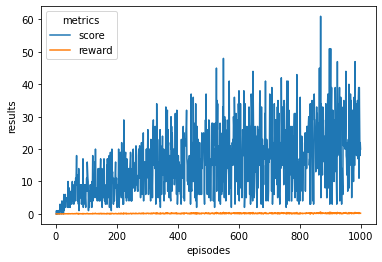

Run time: 25.40072512626648 seconds
Max. Score: 61
Mean Last Scores: 23.8


In [29]:
N0 = 2
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### Experimento 3: Variando a função de recompensa


Game 1      Score: 1
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 2
Game 5      Score: 2
Game 6      Score: 4
Game 7      Score: 2
Game 8      Score: 3
Game 9      Score: 3
Game 10      Score: 2
Game 11      Score: 4
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 10
Game 15      Score: 6
Game 16      Score: 2
Game 17      Score: 1
Game 18      Score: 6
Game 19      Score: 6
Game 20      Score: 1
Game 21      Score: 4
Game 22      Score: 6
Game 23      Score: 8
Game 24      Score: 6
Game 25      Score: 6
Game 26      Score: 8
Game 27      Score: 11
Game 28      Score: 10
Game 29      Score: 2
Game 30      Score: 5
Game 31      Score: 3
Game 32      Score: 7
Game 33      Score: 3
Game 34      Score: 6
Game 35      Score: 6
Game 36      Score: 2
Game 37      Score: 11
Game 38      Score: 9
Game 39      Score: 5
Game 40      Score: 4
Game 41      Score: 7
Game 42      Score: 5
Game 43      Score: 2
Game 44      Score: 3
Game 45      Score: 4
Game 46      Sc

Game 354      Score: 21
Game 355      Score: 12
Game 356      Score: 35
Game 357      Score: 23
Game 358      Score: 38
Game 359      Score: 40
Game 360      Score: 15
Game 361      Score: 10
Game 362      Score: 12
Game 363      Score: 12
Game 364      Score: 14
Game 365      Score: 14
Game 366      Score: 15
Game 367      Score: 10
Game 368      Score: 9
Game 369      Score: 42
Game 370      Score: 26
Game 371      Score: 16
Game 372      Score: 9
Game 373      Score: 22
Game 374      Score: 22
Game 375      Score: 23
Game 376      Score: 29
Game 377      Score: 37
Game 378      Score: 26
Game 379      Score: 12
Game 380      Score: 41
Game 381      Score: 17
Game 382      Score: 17
Game 383      Score: 22
Game 384      Score: 39
Game 385      Score: 22
Game 386      Score: 32
Game 387      Score: 4
Game 388      Score: 14
Game 389      Score: 19
Game 390      Score: 36
Game 391      Score: 27
Game 392      Score: 28
Game 393      Score: 31
Game 394      Score: 41
Game 395      Score

Game 698      Score: 33
Game 699      Score: 31
Game 700      Score: 20
Game 701      Score: 22
Game 702      Score: 21
Game 703      Score: 32
Game 704      Score: 28
Game 705      Score: 30
Game 706      Score: 27
Game 707      Score: 21
Game 708      Score: 30
Game 709      Score: 16
Game 710      Score: 18
Game 711      Score: 34
Game 712      Score: 19
Game 713      Score: 15
Game 714      Score: 24
Game 715      Score: 13
Game 716      Score: 20
Game 717      Score: 15
Game 718      Score: 30
Game 719      Score: 12
Game 720      Score: 9
Game 721      Score: 40
Game 722      Score: 28
Game 723      Score: 28
Game 724      Score: 19
Game 725      Score: 13
Game 726      Score: 10
Game 727      Score: 25
Game 728      Score: 20
Game 729      Score: 29
Game 730      Score: 16
Game 731      Score: 37
Game 732      Score: 16
Game 733      Score: 29
Game 734      Score: 27
Game 735      Score: 45
Game 736      Score: 17
Game 737      Score: 43
Game 738      Score: 22
Game 739      Sco

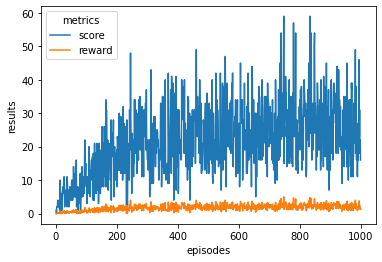

Run time: 33.5823757648468 seconds
Max. Score: 59
Mean Last Scores: 24.58


In [31]:
def reward1(env):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -1 otherwise
    """
    reward = -1
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100

    return reward
    

N0 = 1.0
gamma = 0.99

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=reward1, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [32]:
import math
from scipy.spatial.distance import cityblock

def reward_exp(env, max_value, max_dist=3, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        +max_value * exp(dist[snake, food]) if dist[snake, food] <= max_dist
        -0.01*non_improvement otherwise
    """
    global non_improvement
    
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = dist_metric(player_pos, player_pos)
    
    reward = max_value * math.exp(dist)
    if env.game.crash:
        reward = -1000
    elif env.player.eaten:
        reward = 1000
        non_improvement = 0
    elif dist >= max_dist:
        reward = -non_improvement*0.01
        non_improvement += 1

    return reward

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 1
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 2
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 3
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 1
Game 39      Score: 3
Game 40      Score: 1
Game 41      Score: 1
Game 42      Score: 4
Game 43      Score: 1
Game 44      Score: 1
Game 45      Score: 2
Game 46      Score:

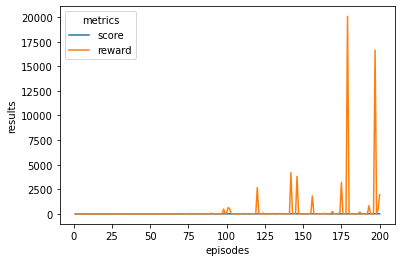

Run time: 600.0072150230408 seconds
Max. Score: 30
Mean Last Scores: 9.92


In [33]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_exp(env, max_value=10),
                         episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [34]:
import math
from scipy.spatial.distance import cityblock

def reward_linear(env, penalty_rate=0.01, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -0.01*non_improvement otherwise
    """
    global non_improvement
    reward = -non_improvement*penalty_rate
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100
        non_improvement = 0
    else:
        non_improvement += 1

    return reward

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 1
Game 15      Score: 2
Game 16      Score: 4
Game 17      Score: 4
Game 18      Score: 6
Game 19      Score: 2
Game 20      Score: 8
Game 21      Score: 3
Game 22      Score: 1
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 9
Game 26      Score: 7
Game 27      Score: 4
Game 28      Score: 12
Game 29      Score: 15
Game 30      Score: 4
Game 31      Score: 11
Game 32      Score: 5
Game 33      Score: 3
Game 34      Score: 6
Game 35      Score: 13
Game 36      Score: 6
Game 37      Score: 4
Game 38      Score: 1
Game 39      Score: 9
Game 40      Score: 8
Game 41      Score: 5
Game 42      Score: 8
Game 43      Score: 4
Game 44      Score: 11
Game 45      Score: 4
Game 46      S

Game 359      Score: 16
Game 360      Score: 2
Game 361      Score: 21
Game 362      Score: 19
Game 363      Score: 13
Game 364      Score: 28
Game 365      Score: 15
Game 366      Score: 26
Game 367      Score: 18
Game 368      Score: 4
Game 369      Score: 2
Game 370      Score: 10
Game 371      Score: 23
Game 372      Score: 34
Game 373      Score: 15
Game 374      Score: 7
Game 375      Score: 21
Game 376      Score: 26
Game 377      Score: 11
Game 378      Score: 38
Game 379      Score: 5
Game 380      Score: 29
Game 381      Score: 21
Game 382      Score: 23
Game 383      Score: 7
Game 384      Score: 9
Game 385      Score: 12
Game 386      Score: 30
Game 387      Score: 11
Game 388      Score: 11
Game 389      Score: 9
Game 390      Score: 8
Game 391      Score: 10
Game 392      Score: 14
Game 393      Score: 13
Game 394      Score: 23
Game 395      Score: 16
Game 396      Score: 6
Game 397      Score: 2
Game 398      Score: 26
Game 399      Score: 12
Game 400      Score: 13
Gam

Game 713      Score: 30
Game 714      Score: 11
Game 715      Score: 20
Game 716      Score: 5
Game 717      Score: 8
Game 718      Score: 19
Game 719      Score: 30
Game 720      Score: 20
Game 721      Score: 25
Game 722      Score: 15
Game 723      Score: 11
Game 724      Score: 38
Game 725      Score: 24
Game 726      Score: 14
Game 727      Score: 10
Game 728      Score: 15
Game 729      Score: 8
Game 730      Score: 34
Game 731      Score: 6
Game 732      Score: 9
Game 733      Score: 24
Game 734      Score: 23
Game 735      Score: 33
Game 736      Score: 28
Game 737      Score: 7
Game 738      Score: 10
Game 739      Score: 31
Game 740      Score: 23
Game 741      Score: 23
Game 742      Score: 3
Game 743      Score: 3
Game 744      Score: 10
Game 745      Score: 12
Game 746      Score: 24
Game 747      Score: 21
Game 748      Score: 4
Game 749      Score: 13
Game 750      Score: 34
Game 751      Score: 23
Game 752      Score: 14
Game 753      Score: 20
Game 754      Score: 29
G

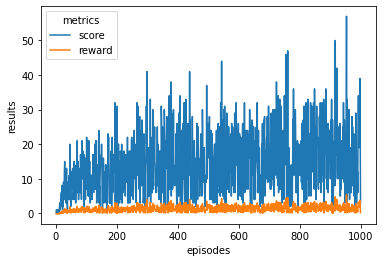

Run time: 18.945865154266357 seconds
Max. Score: 57
Mean Last Scores: 17.1


In [35]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=reward_linear,
                         episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 1
Game 15      Score: 2
Game 16      Score: 4
Game 17      Score: 4
Game 18      Score: 6
Game 19      Score: 2
Game 20      Score: 8
Game 21      Score: 3
Game 22      Score: 1
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 9
Game 26      Score: 7
Game 27      Score: 4
Game 28      Score: 12
Game 29      Score: 15
Game 30      Score: 4
Game 31      Score: 11
Game 32      Score: 5
Game 33      Score: 3
Game 34      Score: 6
Game 35      Score: 13
Game 36      Score: 6
Game 37      Score: 4
Game 38      Score: 1
Game 39      Score: 9
Game 40      Score: 8
Game 41      Score: 4
Game 42      Score: 3
Game 43      Score: 9
Game 44      Score: 7
Game 45      Score: 6
Game 46      Sc

Game 353      Score: 22
Game 354      Score: 24
Game 355      Score: 27
Game 356      Score: 5
Game 357      Score: 32
Game 358      Score: 44
Game 359      Score: 29
Game 360      Score: 18
Game 361      Score: 29
Game 362      Score: 34
Game 363      Score: 35
Game 364      Score: 24
Game 365      Score: 17
Game 366      Score: 17
Game 367      Score: 24
Game 368      Score: 21
Game 369      Score: 29
Game 370      Score: 27
Game 371      Score: 39
Game 372      Score: 24
Game 373      Score: 21
Game 374      Score: 44
Game 375      Score: 21
Game 376      Score: 18
Game 377      Score: 30
Game 378      Score: 23
Game 379      Score: 40
Game 380      Score: 24
Game 381      Score: 9
Game 382      Score: 24
Game 383      Score: 41
Game 384      Score: 27
Game 385      Score: 26
Game 386      Score: 39
Game 387      Score: 38
Game 388      Score: 30
Game 389      Score: 19
Game 390      Score: 23
Game 391      Score: 36
Game 392      Score: 27
Game 393      Score: 36
Game 394      Scor

Game 697      Score: 27
Game 698      Score: 32
Game 699      Score: 29
Game 700      Score: 19
Game 701      Score: 11
Game 702      Score: 35
Game 703      Score: 24
Game 704      Score: 55
Game 705      Score: 8
Game 706      Score: 38
Game 707      Score: 34
Game 708      Score: 31
Game 709      Score: 49
Game 710      Score: 18
Game 711      Score: 45
Game 712      Score: 37
Game 713      Score: 28
Game 714      Score: 13
Game 715      Score: 28
Game 716      Score: 36
Game 717      Score: 47
Game 718      Score: 49
Game 719      Score: 34
Game 720      Score: 20
Game 721      Score: 65
Game 722      Score: 43
Game 723      Score: 20
Game 724      Score: 16
Game 725      Score: 44
Game 726      Score: 53
Game 727      Score: 29
Game 728      Score: 22
Game 729      Score: 16
Game 730      Score: 38
Game 731      Score: 34
Game 732      Score: 18
Game 733      Score: 26
Game 734      Score: 22
Game 735      Score: 24
Game 736      Score: 41
Game 737      Score: 21
Game 738      Sco

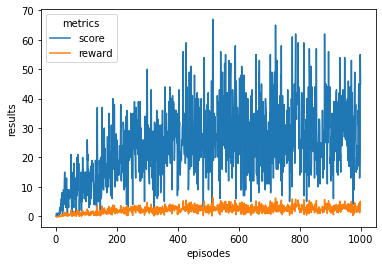

Run time: 26.868289470672607 seconds
Max. Score: 67
Mean Last Scores: 29.24


In [36]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.02),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 1
Game 15      Score: 2
Game 16      Score: 4
Game 17      Score: 2
Game 18      Score: 5
Game 19      Score: 2
Game 20      Score: 1
Game 21      Score: 3
Game 22      Score: 5
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 4
Game 26      Score: 1
Game 27      Score: 10
Game 28      Score: 8
Game 29      Score: 3
Game 30      Score: 2
Game 31      Score: 4
Game 32      Score: 6
Game 33      Score: 3
Game 34      Score: 2
Game 35      Score: 6
Game 36      Score: 4
Game 37      Score: 4
Game 38      Score: 9
Game 39      Score: 6
Game 40      Score: 8
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 10
Game 45      Score: 3
Game 46      Scor

Game 357      Score: 37
Game 358      Score: 30
Game 359      Score: 22
Game 360      Score: 26
Game 361      Score: 29
Game 362      Score: 16
Game 363      Score: 15
Game 364      Score: 38
Game 365      Score: 27
Game 366      Score: 34
Game 367      Score: 17
Game 368      Score: 28
Game 369      Score: 20
Game 370      Score: 40
Game 371      Score: 35
Game 372      Score: 39
Game 373      Score: 29
Game 374      Score: 29
Game 375      Score: 9
Game 376      Score: 15
Game 377      Score: 16
Game 378      Score: 23
Game 379      Score: 33
Game 380      Score: 36
Game 381      Score: 30
Game 382      Score: 20
Game 383      Score: 14
Game 384      Score: 25
Game 385      Score: 24
Game 386      Score: 27
Game 387      Score: 23
Game 388      Score: 31
Game 389      Score: 20
Game 390      Score: 10
Game 391      Score: 17
Game 392      Score: 7
Game 393      Score: 30
Game 394      Score: 13
Game 395      Score: 26
Game 396      Score: 17
Game 397      Score: 28
Game 398      Scor

Game 707      Score: 17
Game 708      Score: 7
Game 709      Score: 37
Game 710      Score: 9
Game 711      Score: 27
Game 712      Score: 25
Game 713      Score: 39
Game 714      Score: 17
Game 715      Score: 23
Game 716      Score: 32
Game 717      Score: 17
Game 718      Score: 6
Game 719      Score: 16
Game 720      Score: 21
Game 721      Score: 27
Game 722      Score: 7
Game 723      Score: 14
Game 724      Score: 30
Game 725      Score: 20
Game 726      Score: 3
Game 727      Score: 8
Game 728      Score: 14
Game 729      Score: 4
Game 730      Score: 16
Game 731      Score: 36
Game 732      Score: 28
Game 733      Score: 19
Game 734      Score: 21
Game 735      Score: 3
Game 736      Score: 22
Game 737      Score: 27
Game 738      Score: 49
Game 739      Score: 27
Game 740      Score: 39
Game 741      Score: 10
Game 742      Score: 4
Game 743      Score: 35
Game 744      Score: 5
Game 745      Score: 17
Game 746      Score: 36
Game 747      Score: 9
Game 748      Score: 18
Gam

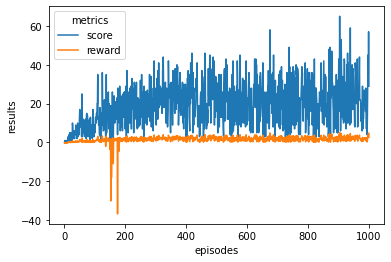

Run time: 23.381409645080566 seconds
Max. Score: 65
Mean Last Scores: 23.34


In [37]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.05),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 1
Game 15      Score: 3
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 3
Game 19      Score: 2
Game 20      Score: 5
Game 21      Score: 5
Game 22      Score: 1
Game 23      Score: 2
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 1
Game 29      Score: 4
Game 30      Score: 1
Game 31      Score: 10
Game 32      Score: 3
Game 33      Score: 5
Game 34      Score: 4
Game 35      Score: 6
Game 36      Score: 10
Game 37      Score: 3
Game 38      Score: 2
Game 39      Score: 6
Game 40      Score: 4
Game 41      Score: 5
Game 42      Score: 3
Game 43      Score: 2
Game 44      Score: 4
Game 45      Score: 4
Game 46      Scor

Game 354      Score: 41
Game 355      Score: 25
Game 356      Score: 29
Game 357      Score: 14
Game 358      Score: 30
Game 359      Score: 21
Game 360      Score: 10
Game 361      Score: 54
Game 362      Score: 35
Game 363      Score: 41
Game 364      Score: 4
Game 365      Score: 16
Game 366      Score: 16
Game 367      Score: 19
Game 368      Score: 23
Game 369      Score: 14
Game 370      Score: 4
Game 371      Score: 54
Game 372      Score: 12
Game 373      Score: 17
Game 374      Score: 27
Game 375      Score: 23
Game 376      Score: 23
Game 377      Score: 21
Game 378      Score: 28
Game 379      Score: 26
Game 380      Score: 26
Game 381      Score: 31
Game 382      Score: 37
Game 383      Score: 39
Game 384      Score: 8
Game 385      Score: 28
Game 386      Score: 47
Game 387      Score: 17
Game 388      Score: 19
Game 389      Score: 31
Game 390      Score: 25
Game 391      Score: 31
Game 392      Score: 61
Game 393      Score: 23
Game 394      Score: 30
Game 395      Score

Game 697      Score: 24
Game 698      Score: 43
Game 699      Score: 23
Game 700      Score: 45
Game 701      Score: 11
Game 702      Score: 52
Game 703      Score: 39
Game 704      Score: 40
Game 705      Score: 24
Game 706      Score: 25
Game 707      Score: 43
Game 708      Score: 34
Game 709      Score: 33
Game 710      Score: 19
Game 711      Score: 60
Game 712      Score: 62
Game 713      Score: 13
Game 714      Score: 41
Game 715      Score: 30
Game 716      Score: 19
Game 717      Score: 5
Game 718      Score: 30
Game 719      Score: 42
Game 720      Score: 43
Game 721      Score: 39
Game 722      Score: 51
Game 723      Score: 45
Game 724      Score: 9
Game 725      Score: 25
Game 726      Score: 14
Game 727      Score: 32
Game 728      Score: 24
Game 729      Score: 43
Game 730      Score: 35
Game 731      Score: 27
Game 732      Score: 41
Game 733      Score: 36
Game 734      Score: 19
Game 735      Score: 17
Game 736      Score: 3
Game 737      Score: 17
Game 738      Score

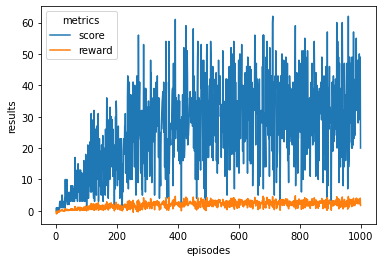

Run time: 35.06679105758667 seconds
Max. Score: 62
Mean Last Scores: 33.5


In [38]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.1),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 2
Game 13      Score: 3
Game 14      Score: 1
Game 15      Score: 3
Game 16      Score: 3
Game 17      Score: 1
Game 18      Score: 3
Game 19      Score: 2
Game 20      Score: 5
Game 21      Score: 5
Game 22      Score: 1
Game 23      Score: 2
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 2
Game 27      Score: 2
Game 28      Score: 1
Game 29      Score: 4
Game 30      Score: 1
Game 31      Score: 10
Game 32      Score: 3
Game 33      Score: 3
Game 34      Score: 2
Game 35      Score: 4
Game 36      Score: 1
Game 37      Score: 3
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 5
Game 43      Score: 6
Game 44      Score: 4
Game 45      Score: 1
Game 46      Score

Game 353      Score: 38
Game 354      Score: 33
Game 355      Score: 14
Game 356      Score: 21
Game 357      Score: 20
Game 358      Score: 27
Game 359      Score: 30
Game 360      Score: 24
Game 361      Score: 27
Game 362      Score: 22
Game 363      Score: 19
Game 364      Score: 35
Game 365      Score: 26
Game 366      Score: 26
Game 367      Score: 14
Game 368      Score: 41
Game 369      Score: 15
Game 370      Score: 13
Game 371      Score: 38
Game 372      Score: 29
Game 373      Score: 20
Game 374      Score: 24
Game 375      Score: 17
Game 376      Score: 47
Game 377      Score: 22
Game 378      Score: 23
Game 379      Score: 22
Game 380      Score: 22
Game 381      Score: 23
Game 382      Score: 37
Game 383      Score: 30
Game 384      Score: 49
Game 385      Score: 15
Game 386      Score: 30
Game 387      Score: 45
Game 388      Score: 19
Game 389      Score: 34
Game 390      Score: 37
Game 391      Score: 28
Game 392      Score: 39
Game 393      Score: 32
Game 394      Sc

Game 700      Score: 26
Game 701      Score: 44
Game 702      Score: 13
Game 703      Score: 43
Game 704      Score: 39
Game 705      Score: 49
Game 706      Score: 43
Game 707      Score: 33
Game 708      Score: 33
Game 709      Score: 36
Game 710      Score: 19
Game 711      Score: 33
Game 712      Score: 42
Game 713      Score: 46
Game 714      Score: 23
Game 715      Score: 52
Game 716      Score: 6
Game 717      Score: 35
Game 718      Score: 23
Game 719      Score: 44
Game 720      Score: 14
Game 721      Score: 50
Game 722      Score: 20
Game 723      Score: 39
Game 724      Score: 39
Game 725      Score: 52
Game 726      Score: 44
Game 727      Score: 20
Game 728      Score: 23
Game 729      Score: 47
Game 730      Score: 40
Game 731      Score: 30
Game 732      Score: 18
Game 733      Score: 22
Game 734      Score: 44
Game 735      Score: 15
Game 736      Score: 40
Game 737      Score: 41
Game 738      Score: 31
Game 739      Score: 38
Game 740      Score: 46
Game 741      Sco

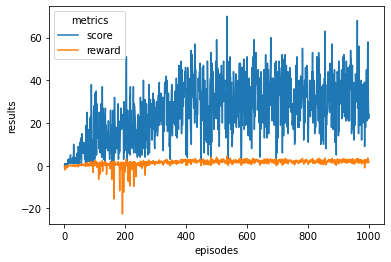

Run time: 33.82561230659485 seconds
Max. Score: 70
Mean Last Scores: 31.86


In [39]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.2),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 0
Game 15      Score: 2
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 2
Game 20      Score: 2
Game 21      Score: 1
Game 22      Score: 3
Game 23      Score: 2
Game 24      Score: 1
Game 25      Score: 3
Game 26      Score: 1
Game 27      Score: 2
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 2
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 2
Game 35      Score: 2
Game 36      Score: 2
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 2
Game 40      Score: 3
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 4
Game 44      Score: 2
Game 45      Score: 8
Game 46      Score:

Game 355      Score: 29
Game 356      Score: 12
Game 357      Score: 24
Game 358      Score: 33
Game 359      Score: 16
Game 360      Score: 33
Game 361      Score: 6
Game 362      Score: 23
Game 363      Score: 36
Game 364      Score: 19
Game 365      Score: 28
Game 366      Score: 28
Game 367      Score: 16
Game 368      Score: 31
Game 369      Score: 18
Game 370      Score: 21
Game 371      Score: 28
Game 372      Score: 24
Game 373      Score: 6
Game 374      Score: 11
Game 375      Score: 30
Game 376      Score: 42
Game 377      Score: 34
Game 378      Score: 27
Game 379      Score: 23
Game 380      Score: 3
Game 381      Score: 32
Game 382      Score: 13
Game 383      Score: 21
Game 384      Score: 16
Game 385      Score: 21
Game 386      Score: 22
Game 387      Score: 27
Game 388      Score: 30
Game 389      Score: 19
Game 390      Score: 19
Game 391      Score: 25
Game 392      Score: 21
Game 393      Score: 45
Game 394      Score: 36
Game 395      Score: 8
Game 396      Score:

Game 702      Score: 32
Game 703      Score: 33
Game 704      Score: 40
Game 705      Score: 29
Game 706      Score: 11
Game 707      Score: 35
Game 708      Score: 22
Game 709      Score: 38
Game 710      Score: 41
Game 711      Score: 24
Game 712      Score: 22
Game 713      Score: 21
Game 714      Score: 32
Game 715      Score: 40
Game 716      Score: 19
Game 717      Score: 27
Game 718      Score: 42
Game 719      Score: 35
Game 720      Score: 43
Game 721      Score: 28
Game 722      Score: 31
Game 723      Score: 22
Game 724      Score: 44
Game 725      Score: 8
Game 726      Score: 41
Game 727      Score: 29
Game 728      Score: 48
Game 729      Score: 28
Game 730      Score: 18
Game 731      Score: 28
Game 732      Score: 32
Game 733      Score: 31
Game 734      Score: 28
Game 735      Score: 15
Game 736      Score: 40
Game 737      Score: 42
Game 738      Score: 6
Game 739      Score: 8
Game 740      Score: 19
Game 741      Score: 43
Game 742      Score: 26
Game 743      Score

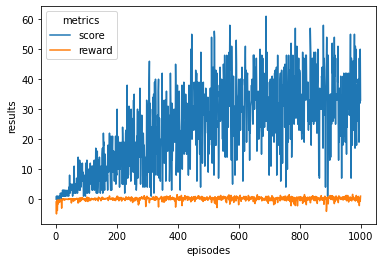

Run time: 32.075374126434326 seconds
Max. Score: 61
Mean Last Scores: 33.56


In [40]:
N0 = 1.0
gamma = 0.99
global non_improvement 
non_improvement = 0

# define agent
sarsaAgent = SARSAAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_sarsa(sarsaAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.5),
                             episodes=1000, speed=0, display=False, verbose=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

## Experimentos com Monte Carlo

### Importações e funções auxiliares

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agent import Agent, QLearningAgent, MonteCarloAgent
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

### Monte Carlo

#### Every Visit

n time: 6.1907875537872314 seconds
Max. Score: 41
Mean Last Scores: 15.8
Game 799      Score: 8
Run time: 6.195788383483887 seconds
Max. Score: 41
Mean Last Scores: 15.64
Game 800      Score: 19
Run time: 6.206790924072266 seconds
Max. Score: 41
Mean Last Scores: 15.74
Game 801      Score: 28
Run time: 6.222794532775879 seconds
Max. Score: 41
Mean Last Scores: 15.8
Game 802      Score: 19
Run time: 6.236797571182251 seconds
Max. Score: 41
Mean Last Scores: 15.96
Game 803      Score: 25
Run time: 6.248800277709961 seconds
Max. Score: 41
Mean Last Scores: 16.16
Game 804      Score: 24
Run time: 6.263803720474243 seconds
Max. Score: 41
Mean Last Scores: 16.5
Game 805      Score: 13
Run time: 6.270805358886719 seconds
Max. Score: 41
Mean Last Scores: 16.24
Game 806      Score: 25
Run time: 6.28480863571167 seconds
Max. Score: 41
Mean Last Scores: 16.36
Game 807      Score: 10
Run time: 6.290809869766235 seconds
Max. Score: 41
Mean Last Scores: 16.16
Game 808      Score: 5
Run time: 6.29381

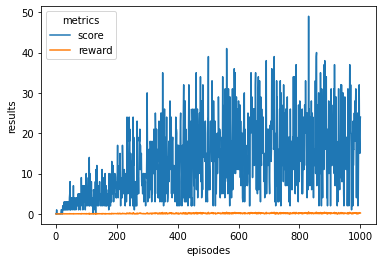

Run time: 8.328271389007568 seconds
Max. Score: 49
Mean Last Scores: 16.84


In [16]:
def run_monte_carlo(agent: Agent, reward_function, episodes, display, speed, verbose=True, first_visit=False):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = {} #defaultdict(float)
    returns_count = {} #defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            states_and_actions_visited.append((state2, action2, reward))

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        #sa_in_episode = set([(tuple(x[0]), x[1]) for x in states_and_actions_visited])
        G = 0
        for i, step in enumerate(states_and_actions_visited[::-1]):
            state, action, r = step
            G = agent.gamma*G + r

            do_update = True

            if first_visit:
                if state in [x[0] for x in states_and_actions_visited[::-1][len(states_and_actions_visited)-i:]]:
                    do_update = False

            if do_update:
                sa_pair = (step[0], decode_action(step[1]))

                if sa_pair in returns_sum:
                    returns_sum[sa_pair] += G
                else:
                    returns_sum[sa_pair] = G

                if sa_pair in returns_count:
                    returns_count[sa_pair] += 1.0
                else:
                    returns_count[sa_pair] = 1

                average = returns_sum[sa_pair] / returns_count[sa_pair]
                agent.Q[sa_pair[0], sa_pair[1] ] = average
                #agent.Q[state, action] = agent.Q[state, action] + 1/returns_count[sa_pair]

        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')


        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        print('Run time:', (end-start), 'seconds')
        print('Max. Score:', max(metrics['scores']))
        print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
    


    return metrics

N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

: 8
Game 159      Score: 6
Game 160      Score: 9
Game 161      Score: 10
Game 162      Score: 8
Game 163      Score: 11
Game 164      Score: 6
Game 165      Score: 14
Game 166      Score: 8
Game 167      Score: 8
Game 168      Score: 6
Game 169      Score: 5
Game 170      Score: 7
Game 171      Score: 5
Game 172      Score: 5
Game 173      Score: 12
Game 174      Score: 4
Game 175      Score: 6
Game 176      Score: 6
Game 177      Score: 15
Game 178      Score: 10
Game 179      Score: 10
Game 180      Score: 25
Game 181      Score: 26
Game 182      Score: 15
Game 183      Score: 8
Game 184      Score: 9
Game 185      Score: 11
Game 186      Score: 28
Game 187      Score: 17
Game 188      Score: 4
Game 189      Score: 14
Game 190      Score: 2
Game 191      Score: 4
Game 192      Score: 14
Game 193      Score: 14
Game 194      Score: 13
Game 195      Score: 21
Game 196      Score: 4
Game 197      Score: 10
Game 198      Score: 11
Game 199      Score: 11
Game 200      Score: 17
Game 201

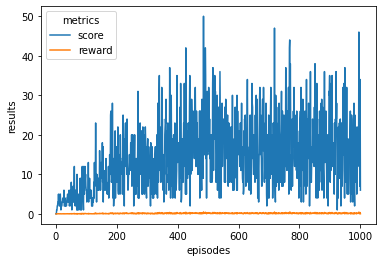

Run time: 10.517382144927979 seconds
Max. Score: 50
Mean Last Scores: 15.2


In [3]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

: 2
Game 132      Score: 4
Game 133      Score: 1
Game 134      Score: 3
Game 135      Score: 4
Game 136      Score: 3
Game 137      Score: 3
Game 138      Score: 3
Game 139      Score: 3
Game 140      Score: 4
Game 141      Score: 3
Game 142      Score: 2
Game 143      Score: 4
Game 144      Score: 1
Game 145      Score: 3
Game 146      Score: 4
Game 147      Score: 3
Game 148      Score: 4
Game 149      Score: 1
Game 150      Score: 2
Game 151      Score: 2
Game 152      Score: 3
Game 153      Score: 2
Game 154      Score: 3
Game 155      Score: 1
Game 156      Score: 3
Game 157      Score: 4
Game 158      Score: 6
Game 159      Score: 2
Game 160      Score: 3
Game 161      Score: 3
Game 162      Score: 3
Game 163      Score: 3
Game 164      Score: 1
Game 165      Score: 4
Game 166      Score: 4
Game 167      Score: 4
Game 168      Score: 3
Game 169      Score: 3
Game 170      Score: 3
Game 171      Score: 3
Game 172      Score: 3
Game 173      Score: 4
Game 174      Score: 4
Game 17

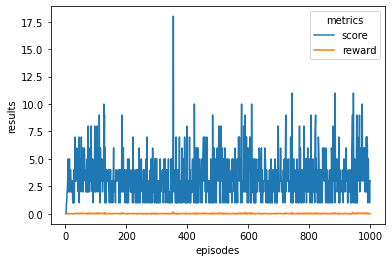

Run time: 4.469013452529907 seconds
Max. Score: 18
Mean Last Scores: 3.98


In [4]:
N0 = 1
gamma = 0.2
# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

#### First Visit

   Score: 0
Game 132      Score: 0
Game 133      Score: 0
Game 134      Score: 0
Game 135      Score: 0
Game 136      Score: 0
Game 137      Score: 0
Game 138      Score: 0
Game 139      Score: 0
Game 140      Score: 0
Game 141      Score: 0
Game 142      Score: 0
Game 143      Score: 0
Game 144      Score: 0
Game 145      Score: 0
Game 146      Score: 0
Game 147      Score: 0
Game 148      Score: 0
Game 149      Score: 0
Game 150      Score: 0
Game 151      Score: 0
Game 152      Score: 0
Game 153      Score: 1
Game 154      Score: 0
Game 155      Score: 0
Game 156      Score: 0
Game 157      Score: 0
Game 158      Score: 0
Game 159      Score: 0
Game 160      Score: 0
Game 161      Score: 0
Game 162      Score: 0
Game 163      Score: 0
Game 164      Score: 0
Game 165      Score: 0
Game 166      Score: 0
Game 167      Score: 0
Game 168      Score: 0
Game 169      Score: 0
Game 170      Score: 0
Game 171      Score: 0
Game 172      Score: 0
Game 173      Score: 0
Game 174      Score: 0

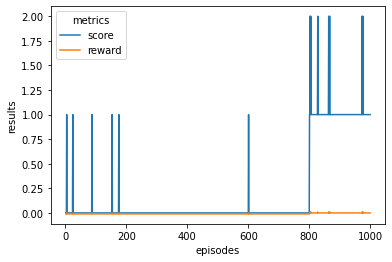

Run time: 2.3245270252227783 seconds
Max. Score: 2
Mean Last Scores: 1.04


In [5]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [12]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Run time: 0.003000497817993164 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 2      Score: 0
Run time: 0.006001472473144531 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 3      Score: 0
Run time: 0.008001327514648438 seconds
Max. Score: 0
Mean Last Scores: 0.0
Game 4      Score: 1
Run time: 0.011001825332641602 seconds
Max. Score: 1
Mean Last Scores: 0.14285714285714285
Game 5      Score: 0
Run time: 0.01300191879272461 seconds
Max. Score: 1
Mean Last Scores: 0.2222222222222222
Game 6      Score: 0
Run time: 0.016002416610717773 seconds
Max. Score: 1
Mean Last Scores: 0.18181818181818182
Game 7      Score: 0
Run time: 0.019003629684448242 seconds
Max. Score: 1
Mean Last Scores: 0.15384615384615385
Game 8      Score: 0
Run time: 0.02100515365600586 seconds
Max. Score: 1
Mean Last Scores: 0.13333333333333333
Game 9      Score: 0
Run time: 0.024004697799682617 seconds
Max. Score: 1
Mean Last Scores: 0.11764705882352941
Game 10      Score: 1
Run time: 0.027005434

KeyboardInterrupt: 

     Score: 8
Game 144      Score: 11
Game 145      Score: 10
Game 146      Score: 5
Game 147      Score: 18
Game 148      Score: 14
Game 149      Score: 5
Game 150      Score: 15
Game 151      Score: 3
Game 152      Score: 8
Game 153      Score: 11
Game 154      Score: 9
Game 155      Score: 4
Game 156      Score: 2
Game 157      Score: 10
Game 158      Score: 9
Game 159      Score: 7
Game 160      Score: 13
Game 161      Score: 8
Game 162      Score: 14
Game 163      Score: 8
Game 164      Score: 6
Game 165      Score: 15
Game 166      Score: 10
Game 167      Score: 7
Game 168      Score: 5
Game 169      Score: 3
Game 170      Score: 9
Game 171      Score: 13
Game 172      Score: 9
Game 173      Score: 9
Game 174      Score: 3
Game 175      Score: 7
Game 176      Score: 7
Game 177      Score: 6
Game 178      Score: 7
Game 179      Score: 1
Game 180      Score: 8
Game 181      Score: 6
Game 182      Score: 8
Game 183      Score: 2
Game 184      Score: 12
Game 185      Score: 4
Game 18

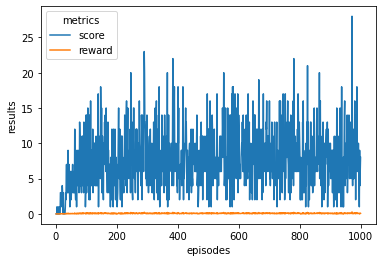

Run time: 10.04140019416809 seconds
Max. Score: 28
Mean Last Scores: 8.44


In [7]:
N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

# Experimentando reward_euclidean no Monte Carlo

## Importações e funções auxiliares

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agent import Agent, QLearningAgent, MonteCarloAgent
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """

    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

pygame 2.0.1 (SDL 2.0.14, Python 3.9.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import math
from scipy.spatial import distance

def reward_euclidean(env):
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = distance.euclidean(player_pos, food_pos)
    reward = 0
    if env.game.crash:
        reward = -10000
    elif env.player.eaten:
        reward = 10000
    else:
        if dist > 100:
            reward = (-1*dist)/10
        if dist <= 100:
            reward = (100-dist)/10

    return reward

# Monte Carlo

### Every Visit

me 194      Score: 4

Game 195      Score: 11

Game 196      Score: 9

Game 197      Score: 15

Game 198      Score: 12

Game 199      Score: 5

Game 200      Score: 13

Game 201      Score: 23

Game 202      Score: 12

Game 203      Score: 20

Game 204      Score: 19

Game 205      Score: 12

Game 206      Score: 6

Game 207      Score: 8

Game 208      Score: 23

Game 209      Score: 10

Game 210      Score: 28

Game 211      Score: 18

Game 212      Score: 25

Game 213      Score: 3

Game 214      Score: 18

Game 215      Score: 19

Game 216      Score: 5

Game 217      Score: 14

Game 218      Score: 16

Game 219      Score: 13

Game 220      Score: 11

Game 221      Score: 22

Game 222      Score: 9

Game 223      Score: 28

Game 224      Score: 5

Game 225      Score: 20

Game 226      Score: 10

Game 227      Score: 11

Game 228      Score: 19

Game 229      Score: 17

Game 230      Score: 15

Game 231      Score: 15

Game 232      Score: 23

Game 233      Score: 18

Game 234   

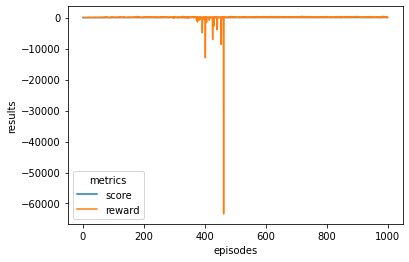

Run time: 166.49454498291016 seconds
Max. Score: 44
Mean Last Scores: 18.6


In [6]:
def run_monte_carlo(agent: Agent, reward_function, episodes, display, speed, verbose=True, first_visit=False):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = {} #defaultdict(float)
    returns_count = {} #defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            states_and_actions_visited.append((state2, action2, reward))

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        #sa_in_episode = set([(tuple(x[0]), x[1]) for x in states_and_actions_visited])
        G = 0
        for i, step in enumerate(states_and_actions_visited[::-1]):
            state, action, r = step
            G = agent.gamma*G + r

            do_update = True

            if first_visit:
                if state in [x[0] for x in states_and_actions_visited[::-1][len(states_and_actions_visited)-i:]]:
                    do_update = False

            if do_update:
                sa_pair = (step[0], decode_action(step[1]))

                if sa_pair in returns_sum:
                    returns_sum[sa_pair] += G
                else:
                    returns_sum[sa_pair] = G

                if sa_pair in returns_count:
                    returns_count[sa_pair] += 1.0
                else:
                    returns_count[sa_pair] = 1

                average = returns_sum[sa_pair] / returns_count[sa_pair]
                agent.Q[sa_pair[0], sa_pair[1] ] = average
                #agent.Q[state, action] = agent.Q[state, action] + 1/returns_count[sa_pair]

        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

        end = time.time()
        diff = end - start
        print()
        if diff > 600: # 10min
            break


    return metrics

N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### First Visit

 Score: 2

Game 176      Score: 5

Game 177      Score: 2

Game 178      Score: 10

Game 179      Score: 3

Game 180      Score: 3

Game 181      Score: 7

Game 182      Score: 6

Game 183      Score: 4

Game 184      Score: 5

Game 185      Score: 5

Game 186      Score: 4

Game 187      Score: 4

Game 188      Score: 13

Game 189      Score: 3

Game 190      Score: 6

Game 191      Score: 2

Game 192      Score: 1

Game 193      Score: 3

Game 194      Score: 9

Game 195      Score: 4

Game 196      Score: 6

Game 197      Score: 4

Game 198      Score: 3

Game 199      Score: 2

Game 200      Score: 2

Game 201      Score: 5

Game 202      Score: 3

Game 203      Score: 7

Game 204      Score: 11

Game 205      Score: 8

Game 206      Score: 6

Game 207      Score: 3

Game 208      Score: 2

Game 209      Score: 8

Game 210      Score: 5

Game 211      Score: 6

Game 212      Score: 4

Game 213      Score: 4

Game 214      Score: 7

Game 215      Score: 6

Game 216      Score: 2

Ga

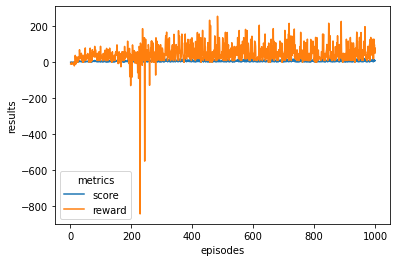

Run time: 99.64312219619751 seconds
Max. Score: 27
Mean Last Scores: 7.48


In [6]:
N0 = 1
gamma = 0.2

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0

Game 2      Score: 0

Game 3      Score: 0

Game 4      Score: 1

Game 5      Score: 0

Game 6      Score: 0

Game 7      Score: 0

Game 8      Score: 0

Game 9      Score: 0

Game 10      Score: 1

Game 11      Score: 0

Game 12      Score: 1

Game 13      Score: 3

Game 14      Score: 2

Game 15      Score: 0

Game 16      Score: 1

Game 17      Score: 0

Game 18      Score: 0

Game 19      Score: 2

Game 20      Score: 0

Game 21      Score: 4

Game 22      Score: 3

Game 23      Score: 0

Game 24      Score: 0

Game 25      Score: 0

Game 26      Score: 0

Game 27      Score: 2

Game 28      Score: 3

Game 29      Score: 1

Game 30      Score: 2

Game 31      Score: 1

Game 32      Score: 1

Game 33      Score: 2

Game 34      Score: 2

Game 35      Score: 4

Game 36      Score: 3

Game 37      Score: 3

Game 38      Score: 2

Game 39      Score: 7

Game 40      Score: 1

Game 41      Score: 0

Game 42      Score: 8

Game 43      Score: 5

Game 44      Score: 

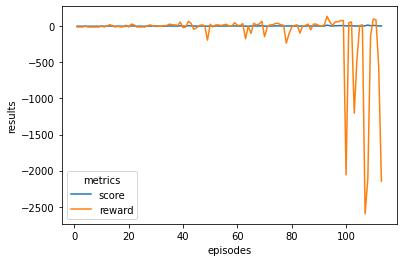

Run time: 1292.8808000087738 seconds
Max. Score: 16
Mean Last Scores: 4.68


In [7]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

re: 0

Game 168      Score: 0

Game 169      Score: 0

Game 170      Score: 0

Game 171      Score: 0

Game 172      Score: 0

Game 173      Score: 0

Game 174      Score: 0

Game 175      Score: 0

Game 176      Score: 0

Game 177      Score: 0

Game 178      Score: 0

Game 179      Score: 0

Game 180      Score: 0

Game 181      Score: 0

Game 182      Score: 0

Game 183      Score: 0

Game 184      Score: 0

Game 185      Score: 0

Game 186      Score: 0

Game 187      Score: 0

Game 188      Score: 0

Game 189      Score: 0

Game 190      Score: 0

Game 191      Score: 0

Game 192      Score: 0

Game 193      Score: 0

Game 194      Score: 0

Game 195      Score: 0

Game 196      Score: 0

Game 197      Score: 0

Game 198      Score: 0

Game 199      Score: 0

Game 200      Score: 0

Game 201      Score: 0

Game 202      Score: 0

Game 203      Score: 0

Game 204      Score: 0

Game 205      Score: 0

Game 206      Score: 0

Game 207      Score: 0

Game 208      Score: 0

Game 209 

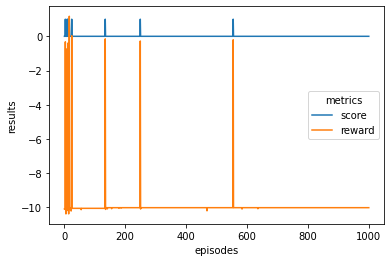

Run time: 2.699418306350708 seconds
Max. Score: 1
Mean Last Scores: 0.0


In [8]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False, first_visit=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

197      Score: 11

Game 198      Score: 10

Game 199      Score: 17

Game 200      Score: 12

Game 201      Score: 11

Game 202      Score: 16

Game 203      Score: 30

Game 204      Score: 25

Game 205      Score: 10

Game 206      Score: 23

Game 207      Score: 16

Game 208      Score: 11

Game 209      Score: 9

Game 210      Score: 9

Game 211      Score: 3

Game 212      Score: 13

Game 213      Score: 6

Game 214      Score: 25

Game 215      Score: 20

Game 216      Score: 16

Game 217      Score: 20

Game 218      Score: 15

Game 219      Score: 10

Game 220      Score: 6

Game 221      Score: 10

Game 222      Score: 24

Game 223      Score: 14

Game 224      Score: 13

Game 225      Score: 20

Game 226      Score: 6

Game 227      Score: 9

Game 228      Score: 13

Game 229      Score: 12

Game 230      Score: 8

Game 231      Score: 18

Game 232      Score: 4

Game 233      Score: 14

Game 234      Score: 3

Game 235      Score: 21

Game 236      Score: 11

Game 237      S

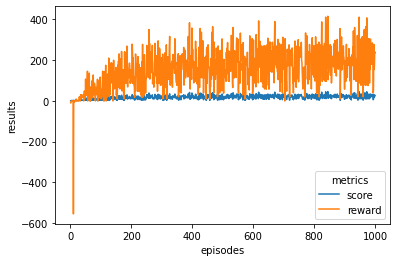

Run time: 32.44448137283325 seconds
Max. Score: 45
Mean Last Scores: 22.22


In [4]:
N0 = 1
gamma = 0.5

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

re: 2

Game 168      Score: 2

Game 169      Score: 3

Game 170      Score: 2

Game 171      Score: 4

Game 172      Score: 6

Game 173      Score: 3

Game 174      Score: 1

Game 175      Score: 1

Game 176      Score: 1

Game 177      Score: 3

Game 178      Score: 0

Game 179      Score: 1

Game 180      Score: 4

Game 181      Score: 2

Game 182      Score: 2

Game 183      Score: 1

Game 184      Score: 1

Game 185      Score: 1

Game 186      Score: 3

Game 187      Score: 3

Game 188      Score: 4

Game 189      Score: 2

Game 190      Score: 1

Game 191      Score: 3

Game 192      Score: 1

Game 193      Score: 2

Game 194      Score: 7

Game 195      Score: 3

Game 196      Score: 2

Game 197      Score: 1

Game 198      Score: 2

Game 199      Score: 2

Game 200      Score: 4

Game 201      Score: 1

Game 202      Score: 4

Game 203      Score: 3

Game 204      Score: 2

Game 205      Score: 1

Game 206      Score: 4

Game 207      Score: 3

Game 208      Score: 2

Game 209 

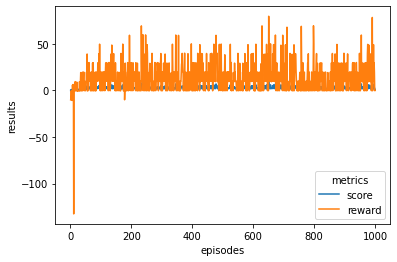

Run time: 5.89633846282959 seconds
Max. Score: 9
Mean Last Scores: 2.96


In [5]:
N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=reward_euclidean, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

## Experimentos com SARSA(lambda)

## Experimentos com Q-Learning e Aproximador Linear de Função

## Experimentos com SARSA e Aproximador Linear de Função

## Experimentos com Monte Carlo e Aproximador Linear de Função

## Experimentos com SARSA(lambda) e Aproximador Linear de Função